# Загрузка и очистка данных

## Библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import requests

In [2]:
# Получение выбросов по столбцу
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col]


# Разделение ячейки Review на список строк, в каждой из которых стоит пара "Обзор"+"Дата обзора"
def get_review_list(s):
    stemp = s.replace('nan', '" "').replace("', ", '<>').replace('",', '').replace("'], ", '<>')
    stemp = stemp.replace('"], ', '<>').replace('"', '')
    lst = re.sub("['\[\]]", '', stemp).split('<>')
    half = int(len(lst)/2)
    res = []
    for i in range(0,half):
        res.append(lst[i]+'^oo^' +lst[i+half])
    if len(res) == 0:
        res.append('^oo^')
    return res


# Разделение столбца со списком на несколько строк и создание датафрейма со старыми ID и разделенными значениями 
def expand_str(df, col_id, col_list):
    serie_list = df[col_list].explode()                # столбец с разделенными значениями строк
    serie_id = df[col_id].str.split().explode()        # столбец с идентификаторами изначальных строк
    df_list = pd.DataFrame({col_list+'1': serie_list, col_id: serie_id}) 
    return df_list


# Получение текста обзора
def get_text_review(s):
    slist = s.split('^oo^')
    if slist[0] == '':
        return None
    else:
        return slist[0]
    
    
# Получение даты обзора
def get_date_review(s):
    slist = s.split('^oo^')
    res = np.datetime64('NaT')
    if slist[1] != '':
        try:
            res = datetime.strptime(slist[1], '%m/%d/%Y')
        except Exception:
            res = np.datetime64('NaT')
    return res


# Получение приблизительной оценки из текста обзора
def get_rev_score(s):
    good_list = ['good', 'nice', 'friendly', 'pleasant', 'fine', 'delicious', 'healthy', 'perfect', 'happy']
    bad_list = ['bad', 'unreasonable', 'unfriendly', 'disappoint', 'poor', 'unpleasant', 'avoid', 'overpriced', 'never']
    terrible_list = ['terrible', 'awful', 'horrible', 'dirty', 'disappoint', 'dreadful', 'disgusting', 'worst', 'rude']
    exellent_list = ['exellent', 'amazing', 'fantastic', 'great', 'wonderful', 'fabulous', 'incredible', 'best', 'awesome']
    
    isTerrible = False
    for item in terrible_list:
        if s.find(item)>0:
            isTerrible = True
            break
    
    if (s.find('not ')>0 and (s.find('not ') < s.find('good'))) or \
       (s.find('not ')>0 and (s.find('not ') < s.find('nice'))) or \
       (s.find('not ')>0 and (s.find('not ') < s.find('friendly'))):
        return 2
    elif s.find('not ')>0 and (s.find('not ') < s.find('bad')) or \
       (s.find('not ')>0 and (s.find('not ') < s.find('terrible'))):
        return 4
    elif isInList(s, terrible_list):
        return 1
    elif isInList(s, bad_list):
        return 2
    elif isInList(s, good_list):
        return 4
    elif isInList(s, exellent_list):
        return 5
    else:
        return 3
    

# Получение признака вхождения слова из списка в заданную строку
def isInList(s, word_list):
    isInList = False
    for word in word_list:
        if s.find(word)>=0:
            isInList = True
            break
    return isInList


# Перевод строковой цены в число
def get_price(s):
    if s is None:
        return 0
    else:
        str_value = str(s).strip()
        if str_value == '$':
            return 1
        elif str_value == '$$ - $$$':
            return 2
        elif str_value == '$$$$':
            return 3
        else:
            return 0

        
# Превращение строки с кухнями в список
def get_cuisines_list(s):
    if s is None:
        return s
    else:
        return re.sub("['\[\]]", '', s).split(', ')
    
    
# Замена 'nan' на None
def set_None(value):
    if value is None:
        return value
    else:
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value

        
# Получение списка данных, обеспечивающих N% объема от суммы количеств значений столбца, 
# а также список прочих значений
def get_top_bottom(column, percent):
    lst_temp = list(column.value_counts())
    tmp_sum = 0
    all_sum = sum(lst_temp)
    top_index = 0

    for cnt in lst_temp:
        tmp_sum += cnt
        if tmp_sum >= all_sum * percent/100:
            top_index = lst_temp.index(cnt)
            break;

    all_val = column.value_counts().index
    top_val = list(all_val)[:top_index]
    bottom_val = list(set(all_val) - set(top_val))
    
    return top_val, bottom_val


# Округление до 0.5
def round_05(val):
    return round(round(val*2, 0) / 2, 1)

## Чтение и первая оценка данных

In [3]:
# Основной набор данных
df = pd.read_csv('main_task.xls')
df.sample(15)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
19485,id_682,Athens,"['Bar', 'Mediterranean', 'Greek', 'Delicatesse...",684.0,4.0,$$ - $$$,23.0,"[['Not bad', 'Excellent Pastries'], ['09/26/20...",/Restaurant_Review-g189400-d9459153-Reviews-Ve...,d9459153
31233,id_5842,Rome,NaN,5844.0,5.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187791-d11841903-Reviews-P...,d11841903
21694,id_951,Copenhagen,"['Italian', 'Pizza', 'European']",953.0,4.0,$$ - $$$,86.0,[['Quaint and tasty! That speaks to all the p....,/Restaurant_Review-g189541-d2388439-Reviews-Ny...,d2388439
39159,id_3768,Paris,NaN,3769.0,4.5,NaN,17.0,"[['Fantastic'], ['10/08/2017']]",/Restaurant_Review-g187147-d12588458-Reviews-S...,d12588458
31173,id_3597,Rome,['Italian'],3598.0,4.5,$$ - $$$,19.0,"[[], []]",/Restaurant_Review-g187791-d12437767-Reviews-R...,d12437767
24869,id_2516,Madrid,"['Mediterranean', 'Spanish', 'European']",2518.0,4.0,$$ - $$$,194.0,[['A little Gem of a restaurant hidden in Mad....,/Restaurant_Review-g187514-d2482055-Reviews-Re...,d2482055
5219,id_694,Dublin,"['Pizza', 'Fast Food', 'Italian']",695.0,4.0,$,64.0,"[['Good for a couple slices', 'Pizza Slice Per...",/Restaurant_Review-g186605-d2654380-Reviews-Ra...,d2654380
7553,id_12829,Paris,['Delicatessen'],12831.0,3.0,$$ - $$$,54.0,"[['SUPER NICE SANDWICHES !!', 'coffee and sand...",/Restaurant_Review-g187147-d719550-Reviews-Lin...,d719550
13690,id_1151,Brussels,"['French', 'Belgian', 'Bar', 'European', 'Vege...",1152.0,3.5,$$ - $$$,122.0,"[['Nice and elegant, good food!', 'it was nice...",/Restaurant_Review-g188644-d8834060-Reviews-La...,d8834060
30479,id_1154,Oporto,['Sushi'],1155.0,3.5,$$ - $$$,23.0,"[['Good sushi', 'Nicely done'], ['06/20/2017',...",/Restaurant_Review-g189180-d5786772-Reviews-QU...,d5786772


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
# Добавим по каждому признаку с пропусками столбец #Пропуск/Не пропуск#
df['isna_Cuisine_Style'] = df['Cuisine Style'].isnull().astype('int')
df['isna_Price_Range'] = df['Price Range'].isnull().astype('int')
df['isna_Num_Rev'] = df['Number of Reviews'].isnull().astype('int')
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev
38533,id_97,Brussels,"['Fast Food', 'European', 'Vegan Options', 'Ve...",98.0,4.5,$$ - $$$,142.0,"[['Great Vegan find!', 'Great juice'], ['02/04...",/Restaurant_Review-g1136501-d7724308-Reviews-G...,d7724308,0,0,0
10118,id_796,Copenhagen,NaN,797.0,4.5,NaN,14.0,"[['Great taste', 'Great authentic Japanese str...",/Restaurant_Review-g189541-d12332633-Reviews-K...,d12332633,1,1,0
13905,id_1661,Stockholm,"['European', 'Swedish']",1664.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189852-d8122532-Reviews-Br...,d8122532,0,1,1
18166,id_1040,Stockholm,['Cafe'],1041.0,4.0,$$ - $$$,22.0,"[['Nice atmosphere', 'Nice plsce to have lunch...",/Restaurant_Review-g189852-d4310992-Reviews-Ca...,d4310992,0,0,0
9176,id_206,London,"['Mediterranean', 'Middle Eastern', 'Israeli',...",207.0,4.5,$$ - $$$,1092.0,"[['One of our favourite places in London', 'As...",/Restaurant_Review-g186338-d6678634-Reviews-Th...,d6678634,0,0,0


In [6]:
# Есть две колонки с ID. Проверим, где больше уникальных значений

display(df.Restaurant_id.value_counts().head(5))
display(df.ID_TA.value_counts().head(5))
print('Уникальных значений Restaurant_id:', len(list(df.Restaurant_id.value_counts())))
print('Уникальных значений ID_TA:', len(list(df.ID_TA.value_counts())))

id_227    18
id_633    18
id_436    18
id_871    18
id_71     17
Name: Restaurant_id, dtype: int64

d2477531     2
d4600226     2
d11674463    2
d10047799    2
d8753348     2
Name: ID_TA, dtype: int64

Уникальных значений Restaurant_id: 11909
Уникальных значений ID_TA: 39980


In [7]:
# И прикинем, чем отличаются строки с одним ID_TA и с одним Restaurant_id

display(df[df.ID_TA=='d8753348'])
display(df[df.Restaurant_id=='id_633'].head(5))

# Вывод: ID_TA - это идентификатор ресторана с некоторыми дублями, которые уберем
# Restaurant_id - это, скорее всего, идентификатор сети ресторанов 

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev
13942,id_1103,Madrid,['Spanish'],1104.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,0,0,0
31238,id_1212,Madrid,['Spanish'],1213.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,0,0,0


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev
836,id_633,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",635.0,3.5,$$ - $$$,743.0,[['Sunshine of Italian pizza in Milan on a we....,/Restaurant_Review-g187849-d7660183-Reviews-Br...,d7660183,0,0,0
2927,id_633,Budapest,['Vegetarian Friendly'],634.0,4.5,$,18.0,"[['Good qualitybreakfast and lovely venue', 'G...",/Restaurant_Review-g274887-d12327467-Reviews-F...,d12327467,0,0,0
4359,id_633,Rome,"['Italian', 'Pizza', 'Fast Food', 'Mediterrane...",634.0,4.5,$,600.0,"[['Cheap, delicious, good service, quick', 'Gr...",/Restaurant_Review-g187791-d3190881-Reviews-Re...,d3190881,0,0,0
4864,id_633,Munich,"['Peruvian', 'Latin', 'South American', 'Veget...",640.0,4.0,$$ - $$$,173.0,"[['Very good but service', 'Nice!'], ['05/13/2...",/Restaurant_Review-g187309-d1674728-Reviews-Na...,d1674728,0,0,0
7188,id_633,Zurich,NaN,637.0,4.0,NaN,20.0,"[['Great coffee in Zurich!', 'Nice wine tastin...",/Restaurant_Review-g188113-d7045067-Reviews-D_...,d7045067,1,1,0


## Столбец URL_TA

In [8]:
# Ссылка содержит 2 числа. Второе - это ID_TA. А что такое первое?
df['g_URL_TA'] = df['URL_TA'].apply(lambda x: x.split('-')[1].replace('g',''))
df[df['g_URL_TA']=='186338'].sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev,g_URL_TA
1038,id_920,London,"['Wine Bar', 'Italian', 'European', 'Mediterra...",922.0,4.5,$$ - $$$,136.0,"[['Pre theatre food', 'Trendy & Friendly'], ['...",/Restaurant_Review-g186338-d6452357-Reviews-Au...,d6452357,0,0,0,186338
24060,id_9607,London,"['International', 'European', 'British', 'Heal...",9616.0,4.5,$,7.0,"[['Try if in the area', 'THE BROWNIES!!!!'], [...",/Restaurant_Review-g186338-d9705129-Reviews-Sa...,d9705129,0,0,0,186338
22508,id_15652,London,"['American', 'British']",15664.0,4.5,$$ - $$$,2.0,[['Good quality burgers near Alexandra Palace'...,/Restaurant_Review-g186338-d12224475-Reviews-T...,d12224475,0,0,0,186338
31286,id_4297,London,"['Indian', 'Asian', 'Bangladeshi', 'Balti', 'E...",4304.0,4.5,$$ - $$$,33.0,"[['Fabulous Indian meal', 'Lovely Takeaway'], ...",/Restaurant_Review-g186338-d2002961-Reviews-Be...,d2002961,0,0,0,186338
26062,id_919,London,"['Italian', 'Pizza', 'European', 'Vegetarian F...",921.0,4.0,$$ - $$$,1160.0,"[['Pre Show Treat', 'Terrific Italian Food, Li...",/Restaurant_Review-g186338-d1113257-Reviews-Ro...,d1113257,0,0,0,186338


In [9]:
# Это код города! Удалим столбец, он дублирует город
df = df.drop(['g_URL_TA'], axis=1)

In [16]:
# Загрузим оценки за питание, обслуживание, атмосферу и цена/качество.
# Оценки были загружены со страниц ресторанов при помощи ссылок из датафрейма
df_score = pd.read_csv('scoreTA.csv')

# Закачка оценок в файл 'scoreTA.csv' проводилась в течение двух суток при помощи такого кода:

# df['score1'] = 0
# df['score2'] = 0
# df['score3'] = 0
# df['score4'] = 0

# for index, row in df.iloc[0:10].iterrows():
#     url = 'https://www.tripadvisor.ru' + row['URL_TA']
#     r = requests.get(url)
#     text = r.text 
    
#     scorestr = '<span class="_2vS3p6SS">Питание</span><span class="_377onWB-"><span class="ui_bubble_rating bubble_'
#     num=text.find(scorestr)
#     if num>=0:
#         score=text[num+len(scorestr):num+len(scorestr)+2]
#         df.at[index, 'score1'] = score
        
#     scorestr = '<span class="_2vS3p6SS">Обслуживание</span><span class="_377onWB-"><span class="ui_bubble_rating bubble_'
#     num=text.find(scorestr)
#     if num>=0:
#         score=text[num+len(scorestr):num+len(scorestr)+2]
#         df.at[index, 'score2'] = score
        
#     scorestr = '<span class="_2vS3p6SS">Атмосфера</span><span class="_377onWB-"><span class="ui_bubble_rating bubble_'
#     num=text.find(scorestr)
#     if num>=0:
#         score=text[num+len(scorestr):num+len(scorestr)+2]
#         df.at[index, 'score3'] = score
        
#     scorestr = '<span class="_2vS3p6SS">Цена/качество</span><span class="_377onWB-"><span class="ui_bubble_rating bubble_'
#     num=text.find(scorestr)
#     if num>=0:
#         score=text[num+len(scorestr):num+len(scorestr)+2]
#         df.at[index, 'score4'] = score

# df.to_csv('scoreDF.csv')
# df_score = pd.read_csv('scoreDF.csv')
# df_score = df_score[['ID_TA','score1','score2','score3','score4']]

# df_score['score1'] = df_score['score1'].fillna(0)
# df_score['score2'] = df_score['score2'].fillna(0)
# df_score['score3'] = df_score['score3'].fillna(0)
# df_score['score4'] = df_score['score4'].fillna(0)

# df_score['score1'] = round(df_score['score1']/10,1)
# df_score['score2'] = round(df_score['score2']/10,1)
# df_score['score3'] = round(df_score['score3']/10,1)
# df_score['score4'] = round(df_score['score4']/10,1)

# df_score['sum_score']=df_score['score1']+df_score['score2']+df_score['score3']+df_score['score4']

# df_score.to_csv('scoreTA.csv', index=False)

In [175]:
# Попробован и альтернативный код. Скорости он не добавил.
# Необходимо разделение на потоки, но работа с потоками пока не изучена

#from bs4 import BeautifulSoup
#from urllib.request import urlopen

#def get_html(url):
#    rs = urlopen(url)
#    root = BeautifulSoup(rs, 'html.parser')
#    return root
    
#for index, row in df.iloc[0:3].iterrows():
#    url = 'https://www.tripadvisor.ru' + row['URL_TA']
#    root = get_html(url) 
#    i = 0
    
#    for a in soup.find_all(class_='_377onWB-'):
#        i += 1
#        astr = str(a)
#        num=astr.find(' bubble_')
#        if num>=0:
#            score=astr[num+8:num+10]
#            df.at[index, 'score'+str(i)] = score

In [18]:
df_score[(df_score.ID_TA=='d1912643') | (df_score.ID_TA=='d7992032')]

,ID_TA,Rating,score1,score2,score3,score4,sum_score
0,d1912643,3.5,3.5,4.0,3.5,3.5,14.5
1,d7992032,4.0,4.5,4.5,0.0,4.5,13.5


In [23]:
df_score[df_score.Rating==5]

,ID_TA,Rating,score1,score2,score3,score4,sum_score
3,d1358776,5.0,4.5,4.5,4.5,4.5,18.0
20,d10524693,5.0,4.0,4.0,3.5,4.0,15.5
25,d12018194,5.0,0.0,0.0,0.0,0.0,0.0
26,d10060659,5.0,4.5,4.0,0.0,4.5,13.0
32,d8791087,5.0,4.5,4.5,4.0,4.5,17.5
...,...,...,...,...,...,...,...
39972,d12981295,5.0,0.0,0.0,0.0,0.0,0.0
39974,d10606787,5.0,0.0,0.0,0.0,0.0,0.0
39984,d11793820,5.0,5.0,5.0,0.0,4.5,14.5
39989,d5550626,5.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df['score1'] = df_score['score1']
df['score2'] = df_score['score2']
df['score3'] = df_score['score3']
df['score4'] = df_score['score4']
df['sum_score'] = df_score['sum_score']

In [43]:
df['score1_c'] = df_score['score1'].apply(lambda x: 2 if x==0 else x)
df['score2_c'] = df_score['score2'].apply(lambda x: 2 if x==0 else x)
df['score3_c'] = df_score['score3'].apply(lambda x: 2 if x==0 else x)
df['score4_c'] = df_score['score4'].apply(lambda x: 2 if x==0 else x)
df['sum_score_c'] = df['score1_c']+df['score2_c']+df['score3_c']+df['score4_c']

#df_score[df_score['score4']>0]['score4'].plot(kind = 'hist', grid = True)

In [44]:
df.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,score1,score2,score3,score4,sum_score,score1_c,score2_c,score3_c,score4_c,sum_score_c
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,3.5,4.0,3.5,3.5,14.5,3.5,4.0,3.5,3.5,14.5
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,4.5,4.5,0.0,4.5,13.5,4.5,4.5,2.0,4.5,15.5


## Столбец Number of Reviews

In [45]:
df[df['Number of Reviews']>=0]['Number of Reviews'].sort_values()

16742       2.0
10733       2.0
37899       2.0
10745       2.0
10748       2.0
          ...  
8516     6777.0
16433    7575.0
15779    7622.0
27027    8927.0
19251    9660.0
Name: Number of Reviews, Length: 37457, dtype: float64

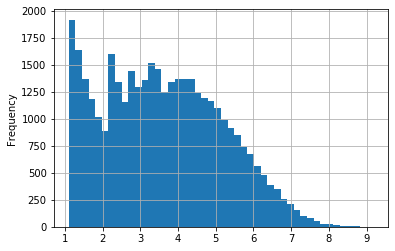

In [46]:
# У значений довольно сильный разброс. Модель может оказаться неустойчивой при таких данных
# Прологарифмируем значения, но предварительно прибавим к значениям 1, чтобы не брать логарифм от 0

df['Num_rev_log'] = np.log(df['Number of Reviews']+1)
df['Num_rev_log'].plot(kind = 'hist', grid = True, bins=46)

# Теперь распределение с некоторой точки выглядит почти нормальным и разброс небольшой.
# А вот левая часть гистограммы очень странная, будто бы у некоторых ресторанов искусственно убрали некоторые обзоры

In [47]:
# Посмотрим на выбросы Num_rev_log 
out = get_outlier(df[df['Num_rev_log']>=0],'Num_rev_log')
print('Количество выбросов:', out.count())
display(out.sort_values())
lim = df.iloc[out.sort_values().index[0]]['Number of Reviews']
print(lim)
# df.boxplot(column=['Num_rev_log'])

Количество выбросов: 12


17588    8.504716
5717     8.559678
21860    8.677780
4817     8.687442
18450    8.701845
39071    8.749891
32909    8.757941
8516     8.821437
16433    8.932741
15779    8.938925
27027    9.096948
19251    9.175852
Name: Num_rev_log, dtype: float64

4937.0


In [48]:
# В столбце Number of Reviews есть пропуски
# Заполним их 0, считая, что отсутствие обзоров = 0
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)
df['Num_rev_log'] = df['Num_rev_log'].fillna(0)

# Выбросы заполним медианой
median = df[df['Number of Reviews']>=0]['Number of Reviews'].median()
df['Num_rev_clear'] = df['Number of Reviews'].apply(lambda x: median if x>lim else x)
df.iloc[19251]

Restaurant_id                                                    id_375
City                                                             London
Cuisine Style         ['British', 'Vegetarian Friendly', 'Gluten Fre...
Ranking                                                             376
Rating                                                                4
Price Range                                                        $$$$
Number of Reviews                                                  9660
Reviews               [['Lovely setting and decent food', 'A Christm...
URL_TA                /Restaurant_Review-g186338-d1421189-Reviews-Lo...
ID_TA                                                          d1421189
isna_Cuisine_Style                                                    0
isna_Price_Range                                                      0
isna_Num_Rev                                                          0
score1                                                          

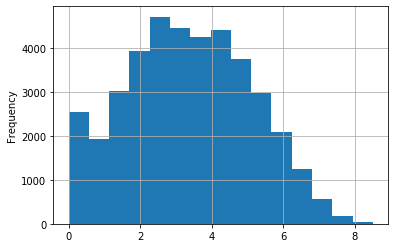

In [49]:
# И снова логарифмируем
df['Num_rev_clear_log'] = np.log(df['Num_rev_clear']+1)
df['Num_rev_clear_log'] = df['Num_rev_clear_log'].fillna(0)
df['Num_rev_clear_log'].plot(kind = 'hist', grid = True, bins=15)

In [50]:
# В итоге для столбца Number of Reviews:
# - заполнили пропуски нулем
# - добавили столбец с заменой выбросов на медиану
# - добавили столбцы с логарифмами от их значений для улучшения устойчивости модели

## Столбец Ranking

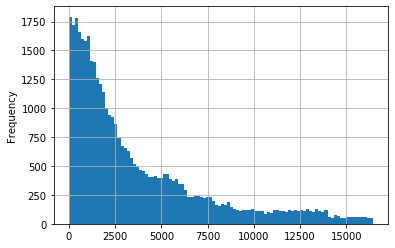

In [51]:
# Столбец Ranking не имеет пропусков. Для него только посмотрим на распределение
df['Ranking'].plot(kind = 'hist', grid = True, bins = 100)

# Разброс очень большой, модель может быть неустойчивой

In [52]:
df['Ranking'].sort_values()

21805        1.0
5936         1.0
21372        1.0
34458        1.0
23201        1.0
          ...   
29405    16420.0
25016    16435.0
18141    16437.0
19545    16441.0
25545    16444.0
Name: Ranking, Length: 40000, dtype: float64

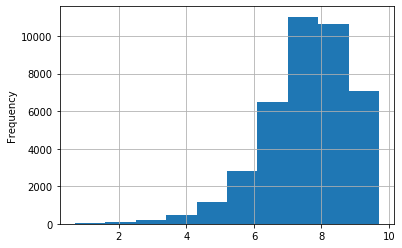

In [53]:
# Прологарифмируем значения, но предварительно прибавим к значениям 1, чтобы не брать логарифм от 0

df['Ranking_log'] = np.log(df['Ranking']+1)
df['Ranking_log'].plot(kind = 'hist', grid = True)

# Теперь распределение похоже на нормальное

In [54]:
# Посмотрим на выбросы Ranking 
out = get_outlier(df,'Ranking')
print('Количество выбросов:', out.count())
display(out.sort_values())
lim = df.iloc[out.sort_values().index[0]]['Ranking']
print(lim)

Количество выбросов: 2450


1566     11691.0
38166    11692.0
2646     11693.0
12508    11694.0
1402     11697.0
          ...   
29405    16420.0
25016    16435.0
18141    16437.0
19545    16441.0
25545    16444.0
Name: Ranking, Length: 2450, dtype: float64

11691.0


In [55]:
# Количество выбросов великовато, но для проверки создадим столбец с заменой выбросов на медиану
median = df['Ranking'].median()
df['Ranking_clear'] = df['Ranking'].apply(lambda x: median if x>lim else x)
df.iloc[25545]

Restaurant_id                                                  id_16422
City                                                             London
Cuisine Style                                                       NaN
Ranking                                                           16444
Rating                                                                1
Price Range                                                         NaN
Number of Reviews                                                     0
Reviews               [["I'm from Singapore and I find the food..."]...
URL_TA                /Restaurant_Review-g186338-d720554-Reviews-Sin...
ID_TA                                                           d720554
isna_Cuisine_Style                                                    1
isna_Price_Range                                                      1
isna_Num_Rev                                                          1
score1                                                          

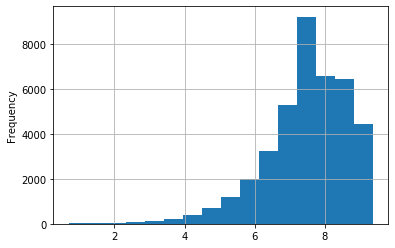

In [56]:
# И снова логарифмируем
df['Ranking_clear_log'] = np.log(df['Ranking_clear']+1)
df['Ranking_clear_log'].plot(kind = 'hist', grid = True, bins=16)

In [57]:
# В итоге для столбца Ranking:
# - добавили столбец с заменой выбросов на медиану
# - добавили столбцы с логарифмами от их значений для улучшения устойчивости модели

## Столбец ID_TA

In [58]:
# Строки с дублями ID_TA отличаются только значимым столбцом Ranking
# Поэтому Ranking приведем к среднему, а потом удалим все дубли, кроме первой строки

#Нашли все повторяющиеся значения ID_TA:
lst_temp = df['ID_TA'].value_counts()[df['ID_TA'].value_counts() > 1].index

# Бежим по всем повторяющимся значениям ID_TA
# В первой строке меняем Ranking на среднее значение по всем строкам-дублям
# Все остальные строки удаляем:
for IDTA in lst_temp:
    indexes = df.loc[df.ID_TA==IDTA].index                # нашли все номера строк-дублей для текущего ID_TA
    meanRank = round(df[df.ID_TA==IDTA].Ranking.mean(),0) # нашли среднее значение Ranking и округлили
    df.at[indexes[0], 'Ranking'] = meanRank               # поменяли в первой строке Ranking на среднее
    for i in range(1, len(df.loc[df.ID_TA==IDTA].index)):
        df = df.drop(indexes[i])                          # удалили все остальные строки
        
        
# Проверяем, как это выглядет
# В дальнейшем после каждой операции тоже станем смотреть на вид преобразованных данных
df.ID_TA.count()

39980

In [59]:
# В итоге столбец ID_TA сделали уникальным идентификатором
# После применения его в подготовке других столбцов, удалим

## Столбец Reviews

In [60]:
# Для начала приведем к культурному виду одну строку, полученную в ходе отладки и сильно мешающую нормально парсить
df.at[22098, 'Reviews'] = "[['It is Indian, Captain, but not as we kno...', 'Avoid'], ['10/09/2016', '06/26/2016']]"

In [67]:
# Превратим кашу из обзоров в список пар "Обзор"+"дата обзора"
df['Review_list'] = df.Reviews.apply(get_review_list)
df.iloc[177,29]

['Great pizza^oo^02/17/2017', 'Dont bother^oo^09/19/2017']

In [68]:
# Получим временный датафрейм с разделенными строками списка
df_temp = expand_str(df, 'ID_TA', 'Review_list')
df_temp.sample(5)

,Review_list1,ID_TA
10440,Great Thai food^oo^02/18/2017,d2492091
24855,Good coffee friendly staff^oo^07/02/2017,d5567535
6159,Lunch after sightseeing^oo^09/19/2017,d2023161
17840,Back to the 70s^oo^12/22/2017,d3308754
36082,Great beer bar^oo^08/30/2017,d813909


In [69]:
# К этому временному датафрейму добавим колонки отдельно с текстом и отдельно с датой обзора
df_temp['Text'] = df_temp.Review_list1.apply(get_text_review)
df_temp['Date'] = df_temp.Review_list1.apply(get_date_review)

# Заполним пропуски: текст пустой строкой, а дату - минимальной из дат минус одна неделя, чтобы отличалось от других дат
df_temp['Text'] = df_temp['Text'].fillna('')
dt_min = df_temp['Date'].min() - timedelta(days=7)
df_temp['Date'] = df_temp['Date'].fillna(dt_min)

df_temp.sample(5)

,Review_list1,ID_TA,Text,Date
34300,hearty traditional italian food. Best Tira...^...,d4685923,hearty traditional italian food. Best Tira...,2018-01-09
20099,Great Halloween Pub Quiz Night! Excellent...^o...,d4419206,Great Halloween Pub Quiz Night! Excellent...,2017-11-18
39957,Tasty pizza and pasta in perfect location^oo^0...,d1226740,Tasty pizza and pasta in perfect location,2018-01-07
17215,Hairdresser or restaurant ?^oo^02/15/2017,d7132962,Hairdresser or restaurant ?,2017-02-15
16352,An ok chinese to get a take away from^oo^06/20...,d5122831,An ok chinese to get a take away from,2015-06-20


In [70]:
# К временному датафрейму добавим столбец с разницей в днях от текущей даты
df_temp['Review_age'] = df_temp.Date.apply(lambda x: (datetime.now() - x).days)

# Из всех обзоров для каждого ресторана выберем минимальную разницу и добавляем к основному датафрейму
df_curr = pd.DataFrame(df_temp.groupby(['ID_TA'])['Review_age'].min().reset_index())
df_curr.columns = ['ID_TA','rev_age_min']
df = df.join(df_curr.set_index('ID_TA'), on='ID_TA')

# Из всех обзоров для каждого ресторана выберем максимальную разницу и добавляем к основному датафрейму
df_curr = pd.DataFrame(df_temp.groupby(['ID_TA'])['Review_age'].max().reset_index())
df_curr.columns = ['ID_TA','rev_age_max']
df = df.join(df_curr.set_index('ID_TA'), on='ID_TA')

# А также добавим разницу в днях между обзорами
df['rev_period'] = df['rev_age_max'] - df['rev_age_min']

df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Num_rev_log,Num_rev_clear,Num_rev_clear_log,Ranking_log,Ranking_clear,Ranking_clear_log,Review_list,rev_age_min,rev_age_max,rev_period
2409,id_5035,London,"['Cafe', 'Fast Food', 'Vegetarian Friendly', '...",5044.0,4.0,$,156.0,[['Good value lunch with wide choice - suitab....,/Restaurant_Review-g186338-d3576897-Reviews-Pr...,d3576897,...,5.056246,156.0,5.056246,8.526153,5044.0,8.526153,[Good value lunch with wide choice - suitab......,1109,1109,0
993,id_611,Geneva,NaN,614.0,5.0,NaN,5.0,"[[], []]",/Restaurant_Review-g4346525-d11812573-Reviews-...,d11812573,...,1.791759,5.0,1.791759,6.421622,614.0,6.421622,[^oo^],6063,6063,0
6463,id_2250,Brussels,NaN,2216.0,4.0,NaN,2.0,[['Nice Italian snacks not far from Magritte.....,/Restaurant_Review-g188644-d10801771-Reviews-S...,d10801771,...,1.098612,2.0,1.098612,7.703910,2216.0,7.703910,[Nice Italian snacks not far from Magritte...^...,1505,1505,0


In [71]:
# Из всех обзоров для каждого ресторана выберем текст самого позднего и добавляем к основному датафрейму
df_curr = df_temp.reset_index()
df_curr = df_curr.loc[df_curr.groupby('ID_TA').Review_age.idxmin()]
df_curr.rename(columns={'Text': 'Text_age_min'}, inplace=True)
df = df.merge(df_curr[['ID_TA','Text_age_min']], on='ID_TA')

# Из всех обзоров для каждого ресторана выберем текст самого раннего и добавляем к основному датафрейму
df_curr = df_temp.reset_index()
df_curr = df_curr.loc[df_curr.groupby('ID_TA').Review_age.idxmax()]
df_curr.rename(columns={'Text': 'Text_age_max'}, inplace=True)
df = df.merge(df_curr[['ID_TA','Text_age_max']], on='ID_TA')

df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Num_rev_clear_log,Ranking_log,Ranking_clear,Ranking_clear_log,Review_list,rev_age_min,rev_age_max,rev_period,Text_age_min,Text_age_max
37420,id_3496,Prague,"['Italian', 'Pizza', 'Fast Food']",3504.0,3.0,NaN,3.0,"[['Hotel Taxi Service', 'Rip off'], ['09/29/20...",/Restaurant_Review-g274707-d7123764-Reviews-Ye...,d7123764,...,1.386294,8.161946,3504.0,8.161946,"[Hotel Taxi Service^oo^09/29/2017, Rip off^oo^...",1147,1407,260,Hotel Taxi Service,Rip off
8939,id_15000,London,['Cafe'],15011.0,3.0,$,19.0,"[['Nice stop for a bite', 'Quick bite.'], ['10...",/Restaurant_Review-g186338-d10397390-Reviews-M...,d10397390,...,2.995732,9.616605,2285.0,7.734559,"[Nice stop for a bite^oo^10/22/2017, Quick bit...",1124,1198,74,Nice stop for a bite,Quick bite.
2897,id_1153,Brussels,"['Italian', 'Pizza', 'Mediterranean']",1154.0,4.0,$$ - $$$,40.0,"[['Great pizza in a scenic setting'], ['05/06/...",/Restaurant_Review-g188644-d6652636-Reviews-Le...,d6652636,...,3.713572,7.051856,1154.0,7.051856,[Great pizza in a scenic setting^oo^05/06/2016],1658,1658,0,Great pizza in a scenic setting,Great pizza in a scenic setting
1082,id_1175,Copenhagen,NaN,1169.0,5.0,NaN,0.0,[['Haven of tranquility and quality (service.....,/Restaurant_Review-g189541-d13125687-Reviews-P...,d13125687,...,0.000000,7.064759,1169.0,7.064759,[Haven of tranquility and quality (service...^...,1108,1108,0,Haven of tranquility and quality (service...,Haven of tranquility and quality (service...
4937,id_8541,Madrid,['Cafe'],8548.0,2.5,NaN,12.0,"[['Good to people watch'], ['09/13/2015']]",/Restaurant_Review-g187514-d4560366-Reviews-Na...,d4560366,...,2.564949,9.053570,8548.0,9.053570,[Good to people watch^oo^09/13/2015],1894,1894,0,Good to people watch,Good to people watch


In [72]:
# Переведем все в нижний регистр для последующей оценки фраз
df['Text_age_min'] = df['Text_age_min'].str.lower()
df['Text_age_max'] = df['Text_age_max'].str.lower()

# По ключевым словам обзоров поставим оценки
# Оценка очень и очень условна, но, может быть, улучшит нашу модель
df['review_score_min'] = df.Text_age_min.apply(get_rev_score)
df['review_score_max'] = df.Text_age_max.apply(get_rev_score)

df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Ranking_clear,Ranking_clear_log,Review_list,rev_age_min,rev_age_max,rev_period,Text_age_min,Text_age_max,review_score_min,review_score_max
34478,id_3326,Barcelona,['Healthy'],3327.0,4.0,$$ - $$$,16.0,"[['Good massage, good food, and lots of misco....",/Restaurant_Review-g187497-d2708699-Reviews-Ma...,d2708699,...,3327.0,8.110127,"[Good massage, good food, and lots of misco......",1362,2352,990,"good massage, good food, and lots of misco...",expensive & not professional,4,3
29251,id_1599,Berlin,"['International', 'French', 'Seafood', 'Europe...",1601.0,3.5,$$ - $$$,159.0,"[['Great Beef Tartare!', 'Good food OK service...",/Restaurant_Review-g187323-d715325-Reviews-Gan...,d715325,...,1601.0,7.379008,"[Great Beef Tartare!^oo^11/27/2017, Good food ...",1088,1101,13,great beef tartare!,good food ok service,5,4
35079,id_3816,Barcelona,NaN,3817.0,4.0,NaN,16.0,"[['disaster!', 'Disappointed'], ['06/17/2017',...",/Restaurant_Review-g187497-d11660294-Reviews-R...,d11660294,...,3817.0,8.247482,"[disaster!^oo^06/17/2017, Disappointed^oo^05/1...",1251,1288,37,disaster!,disappointed,3,1
28900,id_5323,Paris,NaN,5324.0,4.5,NaN,27.0,"[['Absolutely Delicious! Fantastic Service!'],...",/Restaurant_Review-g187147-d5965526-Reviews-L_...,d5965526,...,5324.0,8.580168,[Absolutely Delicious! Fantastic Service!^oo^0...,2337,2337,0,absolutely delicious! fantastic service!,absolutely delicious! fantastic service!,4,4
38062,id_897,Hamburg,NaN,899.0,4.5,NaN,6.0,"[[], []]",/Restaurant_Review-g187331-d8372888-Reviews-Wi...,d8372888,...,899.0,6.802395,[^oo^],6063,6063,0,,,3,3


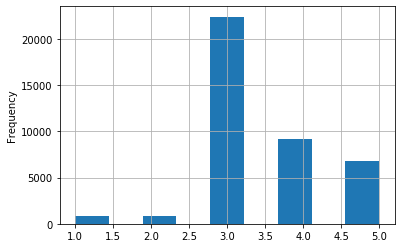

In [73]:
# Посмотрим на распределение получившихся ранних оценок
df['review_score_min'].plot(kind = 'hist', grid = True, bins=9)

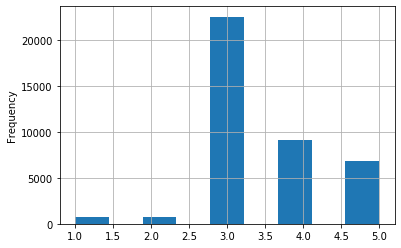

In [74]:
# Посмотрим на распределение получившихся поздних оценок
df['review_score_max'].plot(kind = 'hist', grid = True, bins=9)

# Видно, что распределение напоминает нормальное, но с перекосом в сторону хороших оценок

In [75]:
# В итоге из столбца с обзорами извлекаем:
# - оценки обзоров
# - даты самой ранней и самой поздней оценки
# - разницу в днях между обзорами

## Столбец Restaurant_id

In [76]:
# От столбца с идентификатором сети ресторанов возьмем лишь число ресторанов в этой сети
# Можно предположить, что рейтинг зависит от того, насколько крупная сеть ресторанов, в которую он входит,
# или же ресторан и вовсе не сетевой

df_temp = df['Restaurant_id'].value_counts().reset_index()
df_temp.rename(columns={'index': 'Restaurant_id', 'Restaurant_id': 'Chain'}, inplace=True)
df = df.merge(df_temp, on='Restaurant_id')

df[df.Restaurant_id=='id_5569']

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Ranking_clear_log,Review_list,rev_age_min,rev_age_max,rev_period,Text_age_min,Text_age_max,review_score_min,review_score_max,Chain
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,8.625330,"[Good food at your doorstep^oo^12/31/2017, A g...",1054,1095,41,good food at your doorstep,a good hotel restaurant,4,4,3
1,id_5569,Madrid,"['Mediterranean', 'Spanish']",5572.0,4.0,$$ - $$$,24.0,"[['Excellent food and outstanding service', 'F...",/Restaurant_Review-g187514-d2001176-Reviews-Di...,d2001176,...,8.625689,[Excellent food and outstanding service^oo^09/...,1535,2825,1290,excellent food and outstanding service,fusion tapas,3,3,3
2,id_5569,Milan,"['Italian', 'Mediterranean', 'Vegetarian Frien...",5572.0,3.0,$$ - $$$,127.0,"[['Beautiful Place', 'Lovely place and atmosph...",/Restaurant_Review-g187849-d12429519-Reviews-L...,d12429519,...,8.625689,"[Beautiful Place^oo^12/26/2017, Lovely place a...",1059,1124,65,beautiful place,lovely place and atmosphere,3,3,3


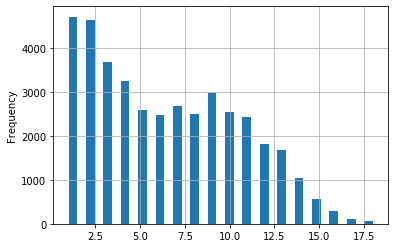

In [77]:
# Посмотрим на распределение
df['Chain'].plot(kind = 'hist', grid = True, bins=35)

# Похоже, что оно склеено из двух нормальных распределений, одно из которых половинчатое
# Возможно, все рестораны было бы правильно разделить на две группы: малая сеть (до 5 включительно) и большая сеть

In [78]:
# Добавим столбец с признаком "Большая-малая сеть"

df['Chain_big'] = df['Chain'].apply(lambda x: 1 if x>5 else 0)
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Review_list,rev_age_min,rev_age_max,rev_period,Text_age_min,Text_age_max,review_score_min,review_score_max,Chain,Chain_big
19617,id_9050,Paris,NaN,9052.0,4.5,NaN,11.0,"[['Great for quick snack', 'Rare Level of Grea...",/Restaurant_Review-g187147-d4801128-Reviews-Le...,d4801128,...,"[Great for quick snack^oo^08/17/2017, Rare Lev...",1190,1242,52,great for quick snack,rare level of great service for a corner s...,5,5,1,0
30969,id_4357,Paris,NaN,4358.0,4.5,NaN,14.0,"[['Great wine', 'A late night cheeseburger, an...",/Restaurant_Review-g187147-d12495310-Reviews-L...,d12495310,...,"[Great wine^oo^10/23/2017, A late night cheese...",1123,1157,34,great wine,"a late night cheeseburger, and he was good",5,4,3,0
15641,id_521,Lyon,"['Irish', 'Bar', 'British', 'Pub', 'Scottish']",522.0,4.0,$,144.0,"[[""Value, atmosphere, good service- What's no....",/Restaurant_Review-g187265-d880985-Reviews-Wal...,d880985,...,"[Value, atmosphere, good service- Whats no... ...",1199,1199,0,"value, atmosphere, good service- whats no... p...","value, atmosphere, good service- whats no... p...",4,4,12,1
4947,id_2601,Prague,"['Italian', 'European']",2607.0,3.5,$$ - $$$,57.0,"[['good cheap eating', 'Hit and miss'], ['10/2...",/Restaurant_Review-g274707-d3174914-Reviews-Ri...,d3174914,...,"[good cheap eating^oo^10/27/2016, Hit and miss...",1484,1558,74,good cheap eating,hit and miss,4,3,3,0
23011,id_2542,Lyon,"['Japanese', 'Sushi']",2543.0,2.5,$$ - $$$,88.0,"[['Good Food', 'Meh.'], ['08/04/2015', '01/08/...",/Restaurant_Review-g187265-d2390888-Reviews-Su...,d2390888,...,"[Good Food^oo^08/04/2015, Meh.^oo^01/08/2014]",1934,2507,573,good food,meh.,4,3,8,1


In [79]:
# В итоге из столбца с идентификатором сети ресторанов извлекаем:
# - количество ресторанов в сети текущего ресторана
# - признак большой или малой сети

## Столбец Price Range

In [80]:
# Посмотрим, что там

df['Price Range'].value_counts()

$$ - $$$    18402
$            6276
$$$$         1423
Name: Price Range, dtype: int64

In [81]:
# Превратим в числовое значение, поскольку это ранжированные строки
# Пустые значения пока заполним нулем

df['Price'] = df['Price Range'].apply(get_price)
df[df.Price==3].sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,rev_age_min,rev_age_max,rev_period,Text_age_min,Text_age_max,review_score_min,review_score_max,Chain,Chain_big,Price
35352,id_84,Stockholm,"['European', 'Swedish', 'Scandinavian', 'Veget...",85.0,4.5,$$$$,465.0,"[['Funny Funny', 'Amazing'], ['12/13/2017', '1...",/Restaurant_Review-g189852-d785390-Reviews-Mat...,d785390,...,1072,1084,12,funny funny,amazing,3,5,9,1,3
31048,id_1715,Madrid,"['Mediterranean', 'Spanish']",1717.0,4.5,$$$$,62.0,"[['found my best restaurant in Madrid !', 'Ext...",/Restaurant_Review-g187514-d5486638-Reviews-Go...,d5486638,...,1102,1107,5,found my best restaurant in madrid !,extensive menu,5,3,6,1,3
9157,id_1329,London,"['Russian', 'Eastern European', 'Vegetarian Fr...",1331.0,4.0,$$$$,476.0,"[[""Like eating in an old aunt's dining room!"",...",/Restaurant_Review-g186338-d3156322-Reviews-Ma...,d3156322,...,1055,1055,0,like eating in an old aunts dining room! worth...,like eating in an old aunts dining room! worth...,3,3,8,1,3


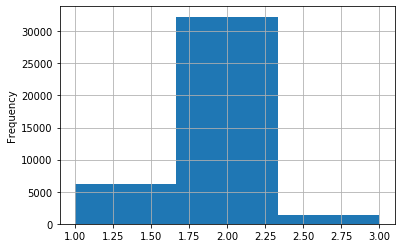

In [82]:
# Заменим нули модой ненулевых цен, то есть число 2
# И добавим столбец,в котором пропуски заполнены средним. Пока непонятно, что лучше

price_mean = df[df.Price>0].Price.mean()
df['Price_mean'] = df['Price'].apply(lambda x: price_mean if x==0 else x)
df['Price'] = df['Price'].apply(lambda x: 2 if x==0 else x)

# И посмотрим на получившееся распределение цен с модой
df['Price'].plot(kind = 'hist', grid = True, bins = 3)

# Распределение почти нормальное

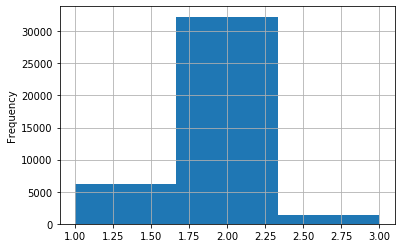

In [83]:
# И посмотрим на получившееся распределение цен со средним
df['Price_mean'].plot(kind = 'hist', grid = True, bins = 3)

In [84]:
# Разница невелика. Удалим столбец с заполнением средним
df = df.drop(['Price_mean'], axis=1)

In [85]:
# В итоге из столбца с ценами извлекаем:
# - цену, переведенную в число

## Столбец City

In [86]:
# Посмотрим, что там

df['City'].value_counts()

# Городов очень много. Скорее всего, не все они играют важную роль для статистики, а только самые частые

London        5757
Paris         4897
Madrid        3088
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [87]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'score1_c', 'score2_c',
       'score3_c', 'score4_c', 'sum_score_c', 'Num_rev_log', 'Num_rev_clear',
       'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'Review_list', 'rev_age_min', 'rev_age_max',
       'rev_period', 'Text_age_min', 'Text_age_max', 'review_score_min',
       'review_score_max', 'Chain', 'Chain_big', 'Price'],
      dtype='object')

In [88]:
# Добавим столбец с численностью городов в тысячах
population = {'Amsterdam': 0.870, 'Barcelona': 3.186, 'Berlin': 3.292, 'Brussels': 1.832, 
              'Hamburg': 1.845, 'Lisbon': 3.186, 'London': 8.908, 'Lyon': 0.507,
              'Madrid': 3.155, 'Milan': 1.332, 'Munich': 1.365, 'Paris': 2.148,
              'Prague': 1.324, 'Rome': 2.880, 'Vienna': 1.897, 'Stockholm' : 1.981,
              'Budapest': 1.752, 'Warsaw': 1.790, 'Dublin': 0.506, 'Copenhagen' : 1.247,
              'Athens': 0.670, 'Edinburgh': 0.500, 'Zurich': 0.430, 'Oporto' : 0.250,
              'Geneva': 0.201, 'Krakow': 0.780, 'Oslo': 0.674, 'Helsinki' : 0.590,
              'Bratislava': 0.438, 'Luxembourg': 0.602, 'Ljubljana' : 0.284
            }
df['City_pop'] = df['City'].map(population)

# Добавим столбцы с отношением количества отзывов к населению
df['rev_pop'] = df['Number of Reviews'] / df['City_pop']
df['rev_pop_clear'] = df['Num_rev_clear'] / df['City_pop']
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Text_age_min,Text_age_max,review_score_min,review_score_max,Chain,Chain_big,Price,City_pop,rev_pop,rev_pop_clear
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,good food at your doorstep,a good hotel restaurant,4,4,3,0,2,2.148,90.316574,90.316574
1,id_5569,Madrid,"['Mediterranean', 'Spanish']",5572.0,4.0,$$ - $$$,24.0,"[['Excellent food and outstanding service', 'F...",/Restaurant_Review-g187514-d2001176-Reviews-Di...,d2001176,...,excellent food and outstanding service,fusion tapas,3,3,3,0,2,3.155,7.606973,7.606973
2,id_5569,Milan,"['Italian', 'Mediterranean', 'Vegetarian Frien...",5572.0,3.0,$$ - $$$,127.0,"[['Beautiful Place', 'Lovely place and atmosph...",/Restaurant_Review-g187849-d12429519-Reviews-L...,d12429519,...,beautiful place,lovely place and atmosphere,3,3,3,0,2,1.332,95.345345,95.345345


In [89]:
# Сделаем столбик с количеством ресторанов в городе
# Может быть, чем больше ресторанов, тем больше конкуренция и выше рейтинги?

df_temp = df['City'].value_counts().reset_index()
df_temp.rename(columns={'index': 'City', 'City': 'Rest_in_city'}, inplace=True)
df = df.merge(df_temp, on='City')
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Text_age_max,review_score_min,review_score_max,Chain,Chain_big,Price,City_pop,rev_pop,rev_pop_clear,Rest_in_city
15045,id_1096,Budapest,"['Italian', 'Gluten Free Options']",1097.0,5.0,$$ - $$$,5.0,"[['Gluten free goodies'], ['08/09/2017']]",/Restaurant_Review-g274887-d10433148-Reviews-N...,d10433148,...,gluten free goodies,4,4,6,1,2,1.752,2.853881,2.853881,816
21329,id_8902,London,['French'],8911.0,5.0,NaN,0.0,"[['Coffee and cake'], ['12/16/2017']]",/Restaurant_Review-g186338-d12969456-Reviews-L...,d12969456,...,coffee and cake,3,3,1,0,2,8.908,0.000000,0.000000,5757
20625,id_14718,London,['American'],14729.0,3.0,NaN,2.0,"[[], []]",/Restaurant_Review-g186338-d5122109-Reviews-Kf...,d5122109,...,,3,3,1,0,2,8.908,0.224517,0.224517,5757
8771,id_1055,Milan,"['Japanese', 'Sushi']",1057.0,4.0,$$ - $$$,210.0,"[['Love it', 'Authentic Japanese'], ['02/09/20...",/Restaurant_Review-g187849-d2481352-Reviews-Sh...,d2481352,...,authentic japanese,3,3,15,1,2,1.332,157.657658,157.657658,2133
7644,id_6918,Madrid,NaN,6921.0,3.5,NaN,7.0,"[['steak house from uruguay'], ['10/31/2016']]",/Restaurant_Review-g187514-d11763133-Reviews-E...,d11763133,...,steak house from uruguay,3,3,2,0,2,3.155,2.218700,2.218700,3088


In [90]:
# Добавим столбец с признаком столицы
capital = {'Amsterdam': 1, 'Barcelona': 0, 'Berlin': 1, 'Brussels': 1, 
              'Hamburg': 0, 'Lisbon': 1, 'London': 1, 'Lyon': 0,
              'Madrid': 1, 'Milan': 0, 'Munich': 0, 'Paris': 1,
              'Prague': 1, 'Rome': 1, 'Vienna': 1, 'Stockholm' : 1,
              'Budapest': 1, 'Warsaw': 1, 'Dublin': 1, 'Copenhagen' : 1,
              'Athens': 1, 'Edinburgh': 0, 'Zurich': 0, 'Oporto' : 0,
              'Geneva': 0, 'Krakow': 0, 'Oslo': 1, 'Helsinki' : 1,
              'Bratislava': 1, 'Luxembourg': 1, 'Ljubljana' : 1
            }
df['City_cap'] = df['City'].map(capital)
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,review_score_min,review_score_max,Chain,Chain_big,Price,City_pop,rev_pop,rev_pop_clear,Rest_in_city,City_cap
35510,id_2085,Prague,['Fast Food'],2088.0,5.0,NaN,0.0,"[[], []]",/Restaurant_Review-g274707-d7124200-Reviews-Pa...,d7124200,...,3,3,6,1,2,1.324,0.000000,0.000000,1443,1
20053,id_4285,London,"['Mediterranean', 'Turkish', 'Delicatessen', '...",4292.0,4.5,$$ - $$$,26.0,"[['Nice food and atmosphere', 'A Turkish Eater...",/Restaurant_Review-g186338-d12165464-Reviews-M...,d12165464,...,4,3,2,0,2,8.908,2.918725,2.918725,5757,1
36688,id_905,Helsinki,NaN,906.0,3.5,NaN,5.0,"[['Affordable, very good pizza', 'Quality pizz...",/Restaurant_Review-g189934-d12430105-Reviews-A...,d12430105,...,4,3,14,1,2,0.590,8.474576,8.474576,376,1


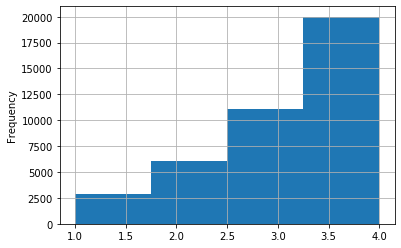

In [91]:
# Добавим столбец с рангом популярности у туристов 
tur = {'Amsterdam': 3, 'Barcelona': 4, 'Berlin': 3, 'Brussels': 3, 
              'Hamburg': 2, 'Lisbon': 3, 'London': 4, 'Lyon': 2,
              'Madrid': 4, 'Milan': 3, 'Munich': 3, 'Paris': 4,
              'Prague': 4, 'Rome': 4, 'Vienna': 3, 'Stockholm' : 2,
              'Budapest': 2, 'Warsaw': 1, 'Dublin': 2, 'Copenhagen' : 3,
              'Athens': 3, 'Edinburgh': 1, 'Zurich': 2, 'Oporto' : 2,
              'Geneva': 2, 'Krakow': 1, 'Oslo': 2, 'Helsinki' : 1,
              'Bratislava': 1, 'Luxembourg': 1, 'Ljubljana' : 1
            }
df['City_tur'] = df['City'].map(tur)
df['City_tur'].plot(kind = 'hist', grid = True, bins = 4)

In [92]:
# Найдем средние значения ранга по городам
df_temp = df.groupby(['City'])['Ranking'].mean().reset_index()
df_temp.rename(columns={'Ranking': 'mean_rank_in_city'}, inplace=True)
df = df.merge(df_temp, on='City')
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Chain,Chain_big,Price,City_pop,rev_pop,rev_pop_clear,Rest_in_city,City_cap,City_tur,mean_rank_in_city
36278,id_4054,Prague,"['European', 'Czech']",4068.0,2.0,NaN,0.0,"[[], []]",/Restaurant_Review-g274707-d11535573-Reviews-M...,d11535573,...,2,0,2,1.324,0.000000,0.000000,1443,1,4,2077.387387
36926,id_964,Helsinki,"['Asian', 'Nepali']",965.0,3.5,NaN,11.0,"[['Nepalese bliss', 'Delicious food, friendly ...",/Restaurant_Review-g189934-d3792616-Reviews-Ra...,d3792616,...,7,1,2,0.590,18.644068,18.644068,376,1,1,566.909574
14557,id_633,Budapest,['Vegetarian Friendly'],634.0,4.5,$,18.0,"[['Good qualitybreakfast and lovely venue', 'G...",/Restaurant_Review-g274887-d12327467-Reviews-F...,d12327467,...,18,1,1,1.752,10.273973,10.273973,816,1,2,1220.811275


In [93]:
# Нормализуем ранг по городам относительно количества ресторанов в городе
df['norm_rank_in_city'] = (df['Ranking'] - df['mean_rank_in_city']) / df['Rest_in_city']
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Chain_big,Price,City_pop,rev_pop,rev_pop_clear,Rest_in_city,City_cap,City_tur,mean_rank_in_city,norm_rank_in_city
18224,id_8452,London,NaN,8461.0,4.0,NaN,9.0,[['Great Sunday pub food with plenty of tv sc....,/Restaurant_Review-g186338-d11892814-Reviews-W...,d11892814,...,0,2,8.908,1.010328,1.010328,5757,1,4,8198.461873,0.045603
33662,id_5250,Barcelona,['Spanish'],5251.0,4.5,NaN,8.0,[['The food is top quality with a great varie....,/Restaurant_Review-g187497-d5865389-Reviews-Pl...,d5865389,...,0,2,3.186,2.510986,2.510986,2734,0,4,3914.144111,0.488974
12905,id_358,Brussels,"['Italian', 'Mediterranean', 'European']",359.0,4.5,$$ - $$$,50.0,"[['Excellent Italian Restaurant!', 'Suburban s...",/Restaurant_Review-g188644-d7034517-Reviews-PA...,d7034517,...,1,2,1.832,27.292576,27.292576,1060,1,3,1535.347170,-1.109761


In [94]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'score1_c', 'score2_c',
       'score3_c', 'score4_c', 'sum_score_c', 'Num_rev_log', 'Num_rev_clear',
       'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'Review_list', 'rev_age_min', 'rev_age_max',
       'rev_period', 'Text_age_min', 'Text_age_max', 'review_score_min',
       'review_score_max', 'Chain', 'Chain_big', 'Price', 'City_pop',
       'rev_pop', 'rev_pop_clear', 'Rest_in_city', 'City_cap', 'City_tur',
       'mean_rank_in_city', 'norm_rank_in_city'],
      dtype='object')

In [95]:
# И то же самое делаем для столбца с замененными выбросами
df_temp = df.groupby(['City'])['Ranking_clear'].mean().reset_index()
df_temp.rename(columns={'Ranking_clear': 'mean_rank_clear_in_city'}, inplace=True)
df = df.merge(df_temp, on='City')
df['norm_rank_clear_in_city'] = (df['Ranking_clear'] - df['mean_rank_clear_in_city']) / df['Rest_in_city']

In [96]:
# Нормализуем количество обзоров по городам относительно количества ресторанов в городе
df_temp = df.groupby(['City'])['Number of Reviews'].mean().reset_index()
df_temp.rename(columns={'Number of Reviews': 'mean_numrev_in_city'}, inplace=True)
df = df.merge(df_temp, on='City')
df['norm_numrev_in_city'] = (df['Number of Reviews'] - df['mean_numrev_in_city']) / df['Rest_in_city']

df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'score1_c', 'score2_c',
       'score3_c', 'score4_c', 'sum_score_c', 'Num_rev_log', 'Num_rev_clear',
       'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'Review_list', 'rev_age_min', 'rev_age_max',
       'rev_period', 'Text_age_min', 'Text_age_max', 'review_score_min',
       'review_score_max', 'Chain', 'Chain_big', 'Price', 'City_pop',
       'rev_pop', 'rev_pop_clear', 'Rest_in_city', 'City_cap', 'City_tur',
       'mean_rank_in_city', 'norm_rank_in_city', 'mean_rank_clear_in_city',
       'norm_rank_clear_in_city', 'mean_numrev_in_city',
       'norm_numrev_in_city'],
      dtype='object')

In [97]:
# И то же самое делаем для столбца с замененными выбросами
df_temp = df.groupby(['City'])['Num_rev_clear'].mean().reset_index()
df_temp.rename(columns={'Num_rev_clear': 'mean_num_rev_clear_in_city'}, inplace=True)
df = df.merge(df_temp, on='City')
df['norm_num_rev_clear_in_city'] = (df['Num_rev_clear'] - df['mean_num_rev_clear_in_city']) / df['Rest_in_city']

In [98]:
# И найдем отношение числа ресторанов в городе к населению
df['rest_pop'] = df['Number of Reviews'] / df['City_pop']
df['rest_pop_clear'] = df['Num_rev_clear'] / df['City_pop']

In [99]:
# Найдем города, которые обеспечивают 80% объема всех строк в датафрейме
# Все остальные города превратим в 'Other City'

top_val, bottom_val = get_top_bottom(df.City, 80)
df.loc[df.City.isin(bottom_val), 'City'] = 'Other City'

# Сделаем из преобразованных городов dummy-переменные

df_temp = pd.get_dummies(df.City)
df = pd.concat([df, df_temp], axis=1)
df[df.City=='Other City'].sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,London,Lyon,Madrid,Milan,Munich,Other City,Paris,Prague,Rome,Vienna
31443,id_282,Other City,['Chinese'],283.0,4.5,$$ - $$$,15.0,"[['Pleasant ambiente', 'Fantastic'], ['01/09/2...",/Restaurant_Review-g190356-d9984762-Reviews-Re...,d9984762,...,0,0,0,0,0,1,0,0,0,0
32185,id_16,Other City,"['Fast Food', 'Portuguese']",17.0,4.5,$,547.0,"[['Cachorrinhos - a must have when in Porto!',...",/Restaurant_Review-g189180-d4341238-Reviews-Ce...,d4341238,...,0,0,0,0,0,1,0,0,0,0


In [100]:
# В итоге из столбца с городами извлекаем:
# - количество ресторанов в городе
# - признак столицы
# - население
# - нормализованное количество отзывов относительно числа ресторанов по городам
# - нормализованный ранг относительно числа ресторанов по городам
# - соотношение количества отзывов относительно населения по городам
# - dummy-переменные по топовым городам и всем остальным, сгруппированным в один фиктивный город

## Столбец Cuisine Style

In [101]:
# В столбце есть незаполненнные данные в виде NaN, 
# превратим их все в None, чтобы не воспринимать NaN как значимое значение 

df['Cuisine Style'] = df['Cuisine Style'].apply(set_None)

In [102]:
# В новый столбец поместим список кухонь, полученный из строки
df['Cuisines'] = df['Cuisine Style'].apply(get_cuisines_list)

# Добавим еще один столбец с количеством кухонь в ресторане. 
# Может быть, чем больше кухонь, тем выше рейтинг?
df['Cuisines_count'] = df['Cuisines'].apply(lambda x: 1 if x is None else len(x))

df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Madrid,Milan,Munich,Other City,Paris,Prague,Rome,Vienna,Cuisines,Cuisines_count
24623,id_491,Other City,"['Cafe', 'Scandinavian', 'Danish', 'European',...",492.0,4.0,$$ - $$$,69.0,"[['Drinks by the water', 'Relaxing Lunch on th...",/Restaurant_Review-g189541-d4131519-Reviews-Ch...,d4131519,...,0,0,0,1,0,0,0,0,"[Cafe, Scandinavian, Danish, European, Contemp...",5
17389,id_13952,London,"['American', 'Indian', 'Pizza', 'European', 'P...",13962.0,3.5,$,4.0,"[['Ok-ish burger meal', 'Great value!'], ['08/...",/Restaurant_Review-g186338-d12416395-Reviews-B...,d12416395,...,0,0,0,0,0,0,0,0,"[American, Indian, Pizza, European, Portuguese]",5
13827,id_1144,Other City,None,1146.0,5.0,NaN,0.0,"[['Asian food, cheap, good quality'], ['03/29/...",/Restaurant_Review-g274856-d12404527-Reviews-S...,d12404527,...,0,0,0,1,0,0,0,0,None,1


In [103]:
# Получим временный датафрейм с разделенными строками списка

df_temp  = expand_str(df, 'ID_TA', 'Cuisines')
df_temp.sample(5)

,Cuisines1,ID_TA
11552,Vegetarian Friendly,d4588301
6975,None,d990744
19454,American,d718559
26427,German,d12347441
12198,Dutch,d3690621


In [104]:
# Посмотрим на количество кухонь

df_temp.Cuisines1.value_counts()

# Их слишком много для dummy-переменных

Vegetarian Friendly    11183
European               10056
Mediterranean           6271
Italian                 5963
Vegan Options           4482
                       ...  
Xinjiang                   1
Yunnan                     1
Burmese                    1
Latvian                    1
Salvadoran                 1
Name: Cuisines1, Length: 125, dtype: int64

In [105]:
df_temp.Cuisines1.unique()

array(['European', 'French', 'International', 'Vegetarian Friendly',
       'Asian', 'Thai', 'Street Food', 'African', 'Ethiopian',
       'Vegan Options', 'Gastropub', 'Vietnamese', 'Seafood',
       'Contemporary', None, 'Korean', 'Central Asian', 'Indian',
       'Japanese', 'Pub', 'Wine Bar', 'Gluten Free Options', 'Italian',
       'Pizza', 'Chinese', 'Bar', 'Cafe', 'Sushi', 'Middle Eastern',
       'Pakistani', 'Moroccan', 'Mediterranean', 'Lebanese', 'American',
       'Soups', 'Brew Pub', 'Healthy', 'Delicatessen', 'Fusion', 'Greek',
       'Argentinean', 'South American', 'Fast Food', 'Belgian', 'Russian',
       'Eastern European', 'Steakhouse', 'Barbecue', 'Nepali',
       'Portuguese', 'Grill', 'Spanish', 'Halal', 'Singaporean', 'Diner',
       'Indonesian', 'Kosher', 'Brazilian', 'Israeli', 'Irish',
       'Tunisian', 'Cambodian', 'Peruvian', 'Arabic', 'Caribbean',
       'Latin', 'Colombian', 'Central American', 'Dutch', 'Scottish',
       'Cuban', 'Swedish', 'Scandinavia

In [106]:
# Заполним пропуски пустой строкой
df_temp.Cuisines1 = df_temp.Cuisines1.fillna('')
df['Cuisine Style'] = df['Cuisine Style'].fillna('')

In [107]:
# Выделим список с типом заведения. Все остальное - типы национальности кухни
# Может быть, те рестораны, что указывают тип, имеют выше рейтинг?
type_rest = ['Street Food','Gastropub','Seafood','Contemporary','Pub',
             'Wine Bar','Pizza','Bar','Cafe','Sushi','Soups','Brew Pub','Healthy',
             'Fast Food', 'Steakhouse', 'Barbecue', 'Grill','Halal',
             'Vegan Options','Vegetarian Friendly','Gluten Free Options','Diner','Kosher']

df['Cuisine_type'] = df['Cuisine Style'].apply(lambda x: 1 if isInList(x,type_rest) else 0) 

In [154]:
df['Cuisines'] = df['Cuisines'].fillna('')

In [167]:
df['Cuisines'].apply(lambda x: 1 if len(set(x) & set(bottom_val)) > 0 else 0)

0        0
1        0
2        1
3        1
4        0
        ..
39975    0
39976    1
39977    1
39978    1
39979    0
Name: Cuisines, Length: 39980, dtype: int64

In [169]:
# Найдем кухни, которые обеспечивают 80% объема всех строк
top_val, bottom_val = get_top_bottom(df_temp.Cuisines1, 80)

# Все остальные кухни превратим в Other и из них сделаем dummy-переменные
for cus in top_val:
    df[cus] = df['Cuisines'].apply(lambda x: 1 if cus in x else 0)
    
df['Other Cuisine'] = df['Cuisines'].apply(lambda x: 1 if len(set(x) & set(bottom_val)) > 0 else 0)
    
df[df['Other Cuisine'] == 1].sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Other Cuisine
38530,id_127,Other City,"['Indian', 'Asian', 'Sri Lankan', 'Vegetarian ...",128.0,4.5,$,148.0,"[['Palmyra - the only dosa place in Norway', '...",/Restaurant_Review-g190479-d1371909-Reviews-Pa...,d1371909,...,0,0,0,0,0,0,0,0,0,1
23954,id_498,Lyon,"['Latin', 'Mediterranean', 'Spanish']",499.0,4.5,$$ - $$$,40.0,"[[], []]",/Restaurant_Review-g187265-d7606924-Reviews-Le...,d7606924,...,0,0,0,0,0,0,0,0,0,1
27814,id_1997,Rome,"['Steakhouse', 'Italian', 'Pizza', 'Vegetarian...",1998.0,4.0,$$ - $$$,185.0,"[['More then just great pizza', 'A Focaccia th...",/Restaurant_Review-g187791-d2542720-Reviews-La...,d2542720,...,0,0,0,0,0,0,0,0,0,1
6094,id_449,Madrid,"['Mexican', 'Latin', 'Vegetarian Friendly', 'G...",450.0,4.0,$$$$,779.0,"[['Delicious dinner in Mezcal Lab', 'Cool expe...",/Restaurant_Review-g187514-d3317463-Reviews-Pu...,d3317463,...,0,0,0,0,0,0,0,0,0,1
33784,id_7234,Barcelona,['Delicatessen'],7235.0,5.0,NaN,0.0,"[['Sunday noon'], ['11/29/2015']]",/Restaurant_Review-g187497-d7096186-Reviews-Se...,d7096186,...,0,0,0,0,0,0,0,0,0,1


In [170]:
# В итоге из столбца с кухнями извлекаем:
# - количество кухонь в ресторане
# - тип кухни
# - dummy-переменные по топовым кухням и всем остальным, сгруппированным в одну фиктивную кухню

## Удаление лишних столбцов и подбор столбцов для модели

In [171]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'score1_c', 'score2_c',
       'score3_c', 'score4_c', 'sum_score_c', 'Num_rev_log', 'Num_rev_clear',
       'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'Review_list', 'rev_age_min', 'rev_age_max',
       'rev_period', 'Text_age_min', 'Text_age_max', 'review_score_min',
       'review_score_max', 'Chain', 'Chain_big', 'Price', 'City_pop',
       'rev_pop', 'rev_pop_clear', 'Rest_in_city', 'City_cap', 'City_tur',
       'mean_rank_in_city', 'norm_rank_in_city', 'mean_rank_clear_in_city',
       'norm_rank_clear_in_city', 'mean_numrev_in_city', 'norm_numrev_in_city',
       'mean_num_rev_clear_in_city', 'norm_num_rev_clear_in_city', 'rest_pop',
       'rest_pop_clear', 'Amsterdam', 'Barce

In [172]:
# Удалим лишний столбец от пустых значений Cuisine Style
df = df.drop([''],axis=1)

In [173]:
# Столбцы с количеством и типами кухонь в ресторане затерялись среди dummy-столбцов. Переместим их
cols = ['Cuisine_type'] + ['Cuisines_count']  + [col for col in df if col != 'Cuisines_count' and col != 'Cuisine_type']
df = df[cols]
df.columns

Index(['Cuisine_type', 'Cuisines_count', 'Restaurant_id', 'City',
       'Cuisine Style', 'Ranking', 'Rating', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'isna_Cuisine_Style',
       'isna_Price_Range', 'isna_Num_Rev', 'score1', 'score2', 'score3',
       'score4', 'sum_score', 'score1_c', 'score2_c', 'score3_c', 'score4_c',
       'sum_score_c', 'Num_rev_log', 'Num_rev_clear', 'Num_rev_clear_log',
       'Ranking_log', 'Ranking_clear', 'Ranking_clear_log', 'Review_list',
       'rev_age_min', 'rev_age_max', 'rev_period', 'Text_age_min',
       'Text_age_max', 'review_score_min', 'review_score_max', 'Chain',
       'Chain_big', 'Price', 'City_pop', 'rev_pop', 'rev_pop_clear',
       'Rest_in_city', 'City_cap', 'City_tur', 'mean_rank_in_city',
       'norm_rank_in_city', 'mean_rank_clear_in_city',
       'norm_rank_clear_in_city', 'mean_numrev_in_city', 'norm_numrev_in_city',
       'mean_num_rev_clear_in_city', 'norm_num_rev_clear_in_city', 'rest_pop',
   

In [174]:
# Отбросим нечисловые столбцы. 
# Столбец Raiting пока оставим для проверки корреляции
# Х - числовые данные с информацией о ресторанах

X = df.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Cuisines',
            'Price Range', 'Reviews', 'URL_TA', 'ID_TA',
            'Review_list', 'Text_age_min', 'Text_age_max'], axis = 1)
X.columns

Index(['Cuisine_type', 'Cuisines_count', 'Ranking', 'Rating',
       'Number of Reviews', 'isna_Cuisine_Style', 'isna_Price_Range',
       'isna_Num_Rev', 'score1', 'score2', 'score3', 'score4', 'sum_score',
       'score1_c', 'score2_c', 'score3_c', 'score4_c', 'sum_score_c',
       'Num_rev_log', 'Num_rev_clear', 'Num_rev_clear_log', 'Ranking_log',
       'Ranking_clear', 'Ranking_clear_log', 'rev_age_min', 'rev_age_max',
       'rev_period', 'review_score_min', 'review_score_max', 'Chain',
       'Chain_big', 'Price', 'City_pop', 'rev_pop', 'rev_pop_clear',
       'Rest_in_city', 'City_cap', 'City_tur', 'mean_rank_in_city',
       'norm_rank_in_city', 'mean_rank_clear_in_city',
       'norm_rank_clear_in_city', 'mean_numrev_in_city', 'norm_numrev_in_city',
       'mean_num_rev_clear_in_city', 'norm_num_rev_clear_in_city', 'rest_pop',
       'rest_pop_clear', 'Amsterdam', 'Barcelona', 'Berlin', 'Brussels',
       'Hamburg', 'Lisbon', 'London', 'Lyon', 'Madrid', 'Milan', 'Munich',
   

In [175]:
# Ищем коррелирующие столбцы. Для проверки корреляции отбросим dummy-столбцы

X.iloc[:,:43].corr()

,Cuisine_type,Cuisines_count,Ranking,Rating,Number of Reviews,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev,score1,score2,...,rev_pop,rev_pop_clear,Rest_in_city,City_cap,City_tur,mean_rank_in_city,norm_rank_in_city,mean_rank_clear_in_city,norm_rank_clear_in_city,mean_numrev_in_city
Cuisine_type,1.000000,0.673550,-0.226624,0.076527,0.293255,-0.554818,-0.557479,-0.172422,0.249160,0.243133,...,0.200646,0.202667,3.173610e-02,2.521925e-02,3.769323e-03,3.175785e-02,-4.324672e-01,-1.235455e-02,-3.851756e-01,1.555884e-01
Cuisines_count,0.673550,1.000000,-0.320319,0.120300,0.405619,-0.490777,-0.566754,-0.175369,0.280768,0.270925,...,0.297791,0.301598,-2.370325e-02,2.015796e-02,-2.787095e-02,-2.388528e-02,-5.410641e-01,-6.110505e-02,-4.891621e-01,1.351069e-01
Ranking,-0.226624,-0.320319,1.000000,-0.368372,-0.222085,0.148018,0.233052,0.094050,-0.203720,-0.202542,...,-0.210357,-0.213069,7.092083e-01,2.241522e-01,5.261247e-01,7.093194e-01,5.682347e-01,6.658442e-01,3.402833e-01,1.106738e-01
Rating,0.076527,0.120300,-0.368372,1.000000,0.027037,-0.038440,-0.064733,0.008438,0.090359,0.094234,...,0.030931,0.031851,-6.121655e-02,1.536706e-02,-4.097979e-02,-6.078332e-02,-5.447112e-01,-7.128650e-02,-3.758948e-01,4.999765e-02
Number of Reviews,0.293255,0.405619,-0.222085,0.027037,1.000000,-0.201281,-0.266752,-0.105861,0.173111,0.164492,...,0.645414,0.583343,2.788202e-02,2.816854e-04,5.273110e-02,2.745079e-02,-4.049083e-01,3.204891e-02,-3.779640e-01,1.759348e-01
isna_Cuisine_Style,-0.554818,-0.490777,0.148018,-0.038440,-0.201281,1.000000,0.753917,0.186153,-0.240051,-0.234602,...,-0.143092,-0.145058,-4.683752e-02,-4.314578e-02,-4.304823e-02,-4.592156e-02,3.212363e-01,-2.439093e-02,2.903404e-01,-1.113764e-01
isna_Price_Range,-0.557479,-0.566754,0.233052,-0.064733,-0.266752,0.753917,1.000000,0.266995,-0.358260,-0.352859,...,-0.190895,-0.193533,-4.410985e-02,-2.929022e-02,-3.429075e-02,-4.316049e-02,4.618683e-01,-2.057588e-02,4.078809e-01,-1.189863e-01
isna_Num_Rev,-0.172422,-0.175369,0.094050,0.008438,-0.105861,0.186153,0.266995,1.000000,-0.251932,-0.254415,...,-0.075642,-0.076782,-2.360219e-02,6.355481e-03,-1.998446e-02,-2.309603e-02,2.061094e-01,-2.410478e-02,1.876480e-01,-5.296897e-02
score1,0.249160,0.280768,-0.203720,0.090359,0.173111,-0.240051,-0.358260,-0.251932,1.000000,0.974136,...,0.129924,0.131517,6.365826e-03,-1.148817e-03,1.045191e-02,5.635249e-03,-3.708613e-01,4.383808e-03,-3.227777e-01,7.518401e-02
score2,0.243133,0.270925,-0.202542,0.094234,0.164492,-0.234602,-0.352859,-0.254415,0.974136,1.000000,...,0.124711,0.126298,5.687315e-03,1.477236e-03,7.121007e-03,4.910986e-03,-3.657005e-01,2.210402e-03,-3.172337e-01,7.177784e-02


In [176]:
# Удалим целевой столбец Rating
X = X.drop(['Rating'], axis = 1)
X.columns

Index(['Cuisine_type', 'Cuisines_count', 'Ranking', 'Number of Reviews',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'score1_c', 'score2_c',
       'score3_c', 'score4_c', 'sum_score_c', 'Num_rev_log', 'Num_rev_clear',
       'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'rev_age_min', 'rev_age_max', 'rev_period',
       'review_score_min', 'review_score_max', 'Chain', 'Chain_big', 'Price',
       'City_pop', 'rev_pop', 'rev_pop_clear', 'Rest_in_city', 'City_cap',
       'City_tur', 'mean_rank_in_city', 'norm_rank_in_city',
       'mean_rank_clear_in_city', 'norm_rank_clear_in_city',
       'mean_numrev_in_city', 'norm_numrev_in_city',
       'mean_num_rev_clear_in_city', 'norm_num_rev_clear_in_city', 'rest_pop',
       'rest_pop_clear', 'Amsterdam', 'Barcelona', 'Berlin', 'Brussels',
       'Hamburg', 'Lisbon', 'London', 'Lyon', 'Madrid', 'Milan', 'Munich',
       'Other

In [268]:
# Далее начинаем экспериментировать с разными наборами столбцов
# X1 = X
# cols = []
# not_list = [4,5,6,8,9,11,12,23,27,29,30,31,33,34,36] #
# not_list = [0, 1, 2, 3, 4, 5, 6, 7] #0.20033816908454227
# not_list = [] 
# not_list = [0,4,5,6,7] + list(range(31,71))

# for i in range(0,len(X.columns)): 
#     if not(i in not_list):
#          cols.append(i)

# print(cols)
# X1 = X1.iloc[:,cols]
# print(X1.columns)

# Без кухонь и городов, кроме Rome и Pizza
cols = ['Cuisine_type', 'Cuisines_count', 'Ranking', 'Number of Reviews',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'Num_rev_log',
       'Num_rev_clear', 'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'rev_age_min', 'rev_age_max', 'rev_period',
       'review_score_min', 'review_score_max', 'Chain', 'Chain_big', 'Price',
       'City_pop', 'rev_pop', 'rev_pop_clear', 'Rest_in_city', 'City_cap',
       'City_tur', 'mean_rank_in_city', 'norm_rank_in_city',
       'mean_rank_clear_in_city', 'norm_rank_clear_in_city',
       'mean_numrev_in_city', 'norm_numrev_in_city',
       'mean_num_rev_clear_in_city', 'norm_num_rev_clear_in_city', 'rest_pop',
       'rest_pop_clear', 'Rome', 'Pizza']



In [177]:
# Экспериментируем с составом столбцов

cols = ['Cuisine_type', 'Cuisines_count', 'Ranking', 'Number of Reviews',
       'isna_Cuisine_Style', 'isna_Price_Range', 'isna_Num_Rev', 'score1',
       'score2', 'score3', 'score4', 'sum_score', 'score1_c', 'score2_c',
       'score3_c', 'score4_c', 'sum_score_c', 'Num_rev_log', 'Num_rev_clear',
       'Num_rev_clear_log', 'Ranking_log', 'Ranking_clear',
       'Ranking_clear_log', 'rev_age_min', 'rev_age_max', 'rev_period',
       'review_score_min', 'review_score_max', 'Chain', 'Chain_big', 'Price',
       'City_pop', 'rev_pop', 'rev_pop_clear', 'Rest_in_city', 'City_cap',
       'City_tur', 'mean_rank_in_city', 'norm_rank_in_city',
       'mean_rank_clear_in_city', 'norm_rank_clear_in_city',
       'mean_numrev_in_city', 'norm_numrev_in_city',
       'mean_num_rev_clear_in_city', 'norm_num_rev_clear_in_city', 'rest_pop',
       'rest_pop_clear', 'Amsterdam', 'Barcelona', 'Berlin', 'Brussels',
       'Hamburg', 'Lisbon', 'London', 'Lyon', 'Madrid', 'Milan', 'Munich',
       'Other City', 'Paris', 'Prague', 'Rome', 'Vienna',
       'Vegetarian Friendly', 'European', 'Mediterranean', 'Italian',
       'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian',
       'Pizza', 'Spanish', 'Pub', 'Cafe', 'Fast Food', 'British',
       'International', 'Seafood', 'Japanese', 'Central European', 'American',
       'Sushi', 'Other Cuisine']

# MAE: 0.1604302151075538
# MAE: 0.16058029014507252
# MAE: 0.1584792396198099
# MAE: 0.15852926463231615
# MAE: 0.1546273136568284
# MAE mean: 0.15852926463231615

X1 = X[cols]
X1

,Cuisine_type,Cuisines_count,Ranking,Number of Reviews,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev,score1,score2,score3,...,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Other Cuisine
0,0,3,5570.0,194.0,0,0,0,3.5,4.0,3.5,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1536.0,25.0,0,0,0,4.5,4.5,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,3457.0,65.0,0,0,0,4.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
3,1,4,616.0,128.0,0,0,0,4.5,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1
4,0,2,1721.0,26.0,0,0,0,4.5,5.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39975,1,1,402.0,4.0,0,1,0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
39976,0,4,91.0,47.0,0,0,0,4.5,4.5,0.0,...,0,0,0,0,0,0,1,0,0,1
39977,1,4,387.0,21.0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
39978,0,2,423.0,9.0,0,0,0,4.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,1


# Разбиваем данные. Создаём, обучаем и тестируем модель

In [178]:
# у - целевая переменная (рейтинги ресторанов)
y = df['Rating']

In [179]:
# Нормализуем данные
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

In [180]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

In [181]:
# Так как результаты отличаются при разных разбиениях, попробуем в цикле несколько раз разбить и обучить модель
# В качестве результата возьмем среднее MAE
res = []
for j in range(0,5):
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25)
    
    # from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.fit_transform(X_test)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)
    
    # Округлим предсказанный вектор оценок
    y_pred_round = np.vectorize(round_05)
    y_pred = y_pred_round(y_pred)

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    res.append(MAE)
    print('MAE:', MAE)
print('MAE mean:', np.mean(res))

MAE: 0.1604302151075538
MAE: 0.16058029014507252
MAE: 0.1584792396198099
MAE: 0.15852926463231615
MAE: 0.1546273136568284
MAE mean: 0.15852926463231615


norm_rank_in_city             0.575938
score1                        0.026285
Number of Reviews             0.023261
Num_rev_log                   0.022725
Num_rev_clear_log             0.022425
norm_numrev_in_city           0.021292
norm_num_rev_clear_in_city    0.019656
score1_c                      0.019403
Num_rev_clear                 0.018940
mean_num_rev_clear_in_city    0.018467
mean_numrev_in_city           0.016350
Rome                          0.012940
rev_age_max                   0.012557
norm_rank_clear_in_city       0.012186
rev_age_min                   0.011086
Ranking                       0.010405
rev_period                    0.009591
Ranking_log                   0.009382
Ranking_clear_log             0.007228
Ranking_clear                 0.007052
dtype: float64

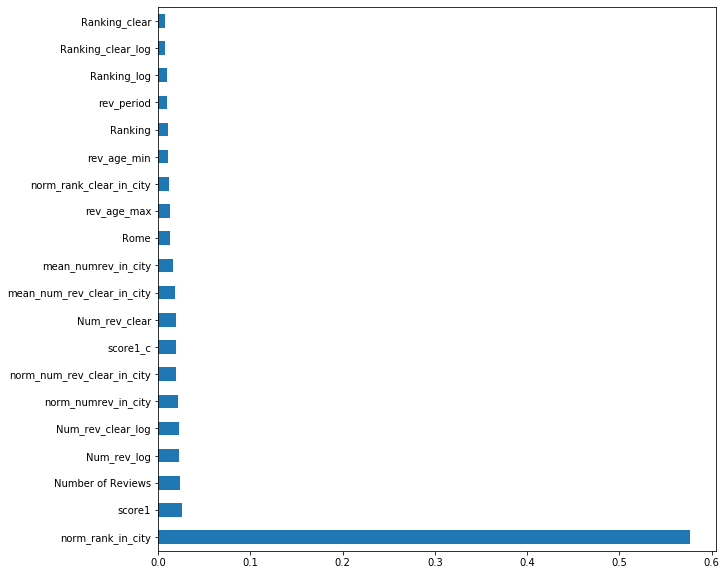

In [183]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
feat_importances.nlargest(20)

# Оборачиваем все в один скрипт

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import requests

In [2]:
# Получение выбросов по столбцу
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col]


# Разделение ячейки Review на список строк, в каждой из которых стоит пара "Обзор"+"Дата обзора"
def get_review_list(s):
    stemp = s.replace('nan', '" "').replace("', ", '<>').replace('",', '').replace("'], ", '<>')
    stemp = stemp.replace('"], ', '<>').replace('"', '')
    lst = re.sub("['\[\]]", '', stemp).split('<>')
    half = int(len(lst)/2)
    res = []
    for i in range(0,half):
        res.append(lst[i]+'^oo^' +lst[i+half])
    if len(res) == 0:
        res.append('^oo^')
    return res


# Разделение столбца со списком на несколько строк и создание датафрейма со старыми ID и разделенными значениями 
def expand_str(df, col_id, col_list):
    serie_list = df[col_list].explode()                # столбец с разделенными значениями строк
    serie_id = df[col_id].str.split().explode()        # столбец с идентификаторами изначальных строк
    df_list = pd.DataFrame({col_list+'1': serie_list, col_id: serie_id}) 
    return df_list


# Получение текста обзора
def get_text_review(s):
    slist = s.split('^oo^')
    if slist[0] == '':
        return None
    else:
        return slist[0]
    
    
# Получение даты обзора
def get_date_review(s):
    slist = s.split('^oo^')
    res = np.datetime64('NaT')
    if slist[1] != '':
        try:
            res = datetime.strptime(slist[1], '%m/%d/%Y')
        except Exception:
            res = np.datetime64('NaT')
    return res


# Получение приблизительной оценки из текста обзора
def get_rev_score(s):
    good_list = ['good', 'nice', 'friendly', 'pleasant', 'fine', 'delicious', 'healthy', 'perfect', 'happy']
    bad_list = ['bad', 'unreasonable', 'unfriendly', 'disappoint', 'poor', 'unpleasant', 'avoid', 'overpriced', 'never']
    terrible_list = ['terrible', 'awful', 'horrible', 'dirty', 'disappoint', 'dreadful', 'disgusting', 'worst', 'rude']
    exellent_list = ['exellent', 'amazing', 'fantastic', 'great', 'wonderful', 'fabulous', 'incredible', 'best', 'awesome']
    
    isTerrible = False
    for item in terrible_list:
        if s.find(item)>0:
            isTerrible = True
            break
    
    if (s.find('not ')>0 and (s.find('not ') < s.find('good'))) or \
       (s.find('not ')>0 and (s.find('not ') < s.find('nice'))) or \
       (s.find('not ')>0 and (s.find('not ') < s.find('friendly'))):
        return 2
    elif s.find('not ')>0 and (s.find('not ') < s.find('bad')) or \
       (s.find('not ')>0 and (s.find('not ') < s.find('terrible'))):
        return 4
    elif isInList(s, terrible_list):
        return 1
    elif isInList(s, bad_list):
        return 2
    elif isInList(s, good_list):
        return 4
    elif isInList(s, exellent_list):
        return 5
    else:
        return 3
    

# Получение признака вхождения слова из списка в заданную строку
def isInList(s, word_list):
    isInList = False
    for word in word_list:
        if s.find(word)>=0:
            isInList = True
            break
    return isInList


# Перевод строковой цены в число
def get_price(s):
    if s is None:
        return 0
    else:
        str_value = str(s).strip()
        if str_value == '$':
            return 1
        elif str_value == '$$ - $$$':
            return 2
        elif str_value == '$$$$':
            return 3
        else:
            return 0

        
# Превращение строки с кухнями в список
def get_cuisines_list(s):
    if s is None:
        return s
    else:
        return re.sub("['\[\]]", '', s).split(', ')
    
    
# Замена 'nan' на None
def set_None(value):
    if value is None:
        return value
    else:
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value

        
# Получение списка данных, обеспечивающих N% объема от суммы количеств значений столбца, 
# а также список прочих значений
def get_top_bottom(column, percent):
    lst_temp = list(column.value_counts())
    tmp_sum = 0
    all_sum = sum(lst_temp)
    top_index = 0

    for cnt in lst_temp:
        tmp_sum += cnt
        if tmp_sum >= all_sum * percent/100:
            top_index = lst_temp.index(cnt)
            break;

    all_val = column.value_counts().index
    top_val = list(all_val)[:top_index]
    bottom_val = list(set(all_val) - set(top_val))
    
    return top_val, bottom_val


# Округление до 0.5
def round_05(val):
    return round(round(val*2, 0) / 2, 1)

In [3]:
# Итоговая функция подготовки данных
def preproc_data(df_input, df_score):
        
    df_output = df_input.copy()
    
    # ###################  Общая предобработка ###############################################
    
    df_output['isna_Cuisine_Style'] = df_output['Cuisine Style'].isnull().astype('int')
    df_output['isna_Price_Range'] = df_output['Price Range'].isnull().astype('int')
    df_output['isna_Num_Rev'] = df_output['Number of Reviews'].isnull().astype('int')
    df_output['Reviews'] = df_output['Reviews'].fillna('[[], []]')
    
    
    # ###################  URL_TA #############################################################
    
    df_output['score1'] = df_score['score1']
    df_output['score2'] = df_score['score2']
    df_output['score3'] = df_score['score3']
    df_output['score4'] = df_score['score4']
    df_output['sum_score'] = df_score['sum_score']
    
    df_output['score1_c'] = df_score['score1'].apply(lambda x: 2 if x==0 else x)
    df_output['score2_c'] = df_score['score2'].apply(lambda x: 2 if x==0 else x)
    df_output['score3_c'] = df_score['score3'].apply(lambda x: 2 if x==0 else x)
    df_output['score4_c'] = df_score['score4'].apply(lambda x: 2 if x==0 else x)
    df_output['sum_score_c'] = df_output['score1_c']+df_output['score2_c']+df_output['score3_c']+df_output['score4_c']
    
    
    
    # ###################  Number of Reviews #################################################
    
    df_output['Num_rev_log'] = np.log(df_output['Number of Reviews']+1)
    
    out = get_outlier(df_output[df_output['Num_rev_log']>=0],'Num_rev_log')
    lim = df_output.iloc[out.sort_values().index[0]]['Number of Reviews']
    
    df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(0)
    df_output['Num_rev_log'] = df_output['Num_rev_log'].fillna(0)

    median = df_output[df_output['Number of Reviews']>=0]['Number of Reviews'].median()
    df_output['Num_rev_clear'] = df_output['Number of Reviews'].apply(lambda x: median if x>lim else x)
    
    df_output['Num_rev_clear_log'] = np.log(df_output['Num_rev_clear']+1)
    df_output['Num_rev_clear_log'] = df_output['Num_rev_clear_log'].fillna(0)

    
    # ###################  Ranking  ##########################################################
    
    df_output['Ranking_log'] = np.log(df_output['Ranking']+1)
    out = get_outlier(df_output,'Ranking')
    lim = df_output.iloc[out.sort_values().index[0]]['Ranking']
    median = df_output['Ranking'].median()
    df_output['Ranking_clear'] = df_output['Ranking'].apply(lambda x: median if x>lim else x)
    df_output['Ranking_clear_log'] = np.log(df_output['Ranking_clear']+1)
    
       
    # ###################  ID_TA   ##########################################################
    
    lst_temp = df_output['ID_TA'].value_counts()[df_output['ID_TA'].value_counts() > 1].index

    for IDTA in lst_temp:
        indexes = df_output.loc[df_output.ID_TA==IDTA].index                
        meanRank = round(df_output[df_output.ID_TA==IDTA].Ranking.mean(),0) 
        df_output.at[indexes[0], 'Ranking'] = meanRank               
        for i in range(1, len(df_output.loc[df_output.ID_TA==IDTA].index)):
            df_output = df_output.drop(indexes[i])   
            
    
    # ###################  Reviews ##########################################################
    
    df_output['Reviews_nonNaN'] = df_output['Reviews'].fillna('[[],[]]')
    df_output['Review_list'] = df_output.Reviews_nonNaN.apply(get_review_list)
    
    df_temp = expand_str(df_output, 'ID_TA', 'Review_list')
    df_temp['Text'] = df_temp.Review_list1.apply(get_text_review)
    df_temp['Date'] = df_temp.Review_list1.apply(get_date_review)
    df_temp['Text'] = df_temp['Text'].fillna('')
    dt_min = df_temp['Date'].min() - timedelta(days=7)
    df_temp['Date'] = df_temp['Date'].fillna(dt_min)
    df_temp['Review_age'] = df_temp.Date.apply(lambda x: (datetime.now() - x).days)

    df_curr = pd.DataFrame(df_temp.groupby(['ID_TA'])['Review_age'].min().reset_index())
    df_curr.columns = ['ID_TA','rev_age_min']
    df_output = df_output.join(df_curr.set_index('ID_TA'), on='ID_TA')

    df_curr = pd.DataFrame(df_temp.groupby(['ID_TA'])['Review_age'].max().reset_index())
    df_curr.columns = ['ID_TA','rev_age_max']
    df_output = df_output.join(df_curr.set_index('ID_TA'), on='ID_TA')

    df_output['rev_period'] = df_output['rev_age_max'] - df_output['rev_age_min']
    
    df_curr = df_temp.reset_index()
    df_curr = df_curr.loc[df_curr.groupby('ID_TA').Review_age.idxmin()]
    df_curr.rename(columns={'Text': 'Text_age_min'}, inplace=True)
    df_output = df_output.merge(df_curr[['ID_TA','Text_age_min']], on='ID_TA')

    df_curr = df_temp.reset_index()
    df_curr = df_curr.loc[df_curr.groupby('ID_TA').Review_age.idxmax()]
    df_curr.rename(columns={'Text': 'Text_age_max'}, inplace=True)
    df_output = df_output.merge(df_curr[['ID_TA','Text_age_max']], on='ID_TA')
    
    df_output['Text_age_min'] = df_output['Text_age_min'].str.lower()
    df_output['Text_age_max'] = df_output['Text_age_max'].str.lower()
    df_output['review_score_min'] = df_output.Text_age_min.apply(get_rev_score)
    df_output['review_score_max'] = df_output.Text_age_max.apply(get_rev_score)
    
    
    # ###################  Restaurant_id #####################################################
    
    df_temp = df_output['Restaurant_id'].value_counts().reset_index()
    df_temp.rename(columns={'index': 'Restaurant_id', 'Restaurant_id': 'Chain'}, inplace=True)
    df_output = df_output.merge(df_temp, on='Restaurant_id')
    df_output['Chain_big'] = df_output['Chain'].apply(lambda x: 1 if x>5 else 0)
    
    
    # ###################  Price Range #######################################################
    
    df_output['Price'] = df_output['Price Range'].apply(get_price)
    df_output['Price'] = df_output['Price'].apply(lambda x: 2 if x==0 else x)
    
    
    # ###################  City ##############################################################
    
    df_temp = df_output['City'].value_counts().reset_index()
    df_temp.rename(columns={'index': 'City', 'City': 'Rest_in_city'}, inplace=True)
    df_output = df_output.merge(df_temp, on='City')

    population = {'Amsterdam': 0.870, 'Barcelona': 3.186, 'Berlin': 3.292, 'Brussels': 1.832, 
              'Hamburg': 1.845, 'Lisbon': 3.186, 'London': 8.908, 'Lyon': 0.507,
              'Madrid': 3.155, 'Milan': 1.332, 'Munich': 1.365, 'Paris': 2.148,
              'Prague': 1.324, 'Rome': 2.880, 'Vienna': 1.897, 'Stockholm' : 1.981,
              'Budapest': 1.752, 'Warsaw': 1.790, 'Dublin': 0.506, 'Copenhagen' : 1.247,
              'Athens': 0.670, 'Edinburgh': 0.500, 'Zurich': 0.430, 'Oporto' : 0.250,
              'Geneva': 0.201, 'Krakow': 0.780, 'Oslo': 0.674, 'Helsinki' : 0.590,
              'Bratislava': 0.438, 'Luxembourg': 0.602, 'Ljubljana' : 0.284
            }
    df_output['City_pop'] = df_output['City'].map(population)
    df_output['rev_pop'] = df_output['Number of Reviews'] / df_output['City_pop']
    df_output['rev_pop_clear'] = df_output['Num_rev_clear'] / df_output['City_pop']

    capital = {'Amsterdam': 1, 'Barcelona': 0, 'Berlin': 1, 'Brussels': 1, 
              'Hamburg': 0, 'Lisbon': 1, 'London': 1, 'Lyon': 0,
              'Madrid': 1, 'Milan': 0, 'Munich': 0, 'Paris': 1,
              'Prague': 1, 'Rome': 1, 'Vienna': 1, 'Stockholm' : 1,
              'Budapest': 1, 'Warsaw': 1, 'Dublin': 1, 'Copenhagen' : 1,
              'Athens': 1, 'Edinburgh': 0, 'Zurich': 0, 'Oporto' : 0,
              'Geneva': 0, 'Krakow': 0, 'Oslo': 1, 'Helsinki' : 1,
              'Bratislava': 1, 'Luxembourg': 1, 'Ljubljana' : 1
            }
    df_output['City_cap'] = df_output['City'].map(capital)
    
    tur = {'Amsterdam': 3, 'Barcelona': 4, 'Berlin': 3, 'Brussels': 3, 
              'Hamburg': 2, 'Lisbon': 3, 'London': 4, 'Lyon': 2,
              'Madrid': 4, 'Milan': 3, 'Munich': 3, 'Paris': 4,
              'Prague': 4, 'Rome': 4, 'Vienna': 3, 'Stockholm' : 2,
              'Budapest': 2, 'Warsaw': 1, 'Dublin': 2, 'Copenhagen' : 3,
              'Athens': 3, 'Edinburgh': 1, 'Zurich': 2, 'Oporto' : 2,
              'Geneva': 2, 'Krakow': 1, 'Oslo': 2, 'Helsinki' : 1,
              'Bratislava': 1, 'Luxembourg': 1, 'Ljubljana' : 1
            }
    df_output['City_tur'] = df_output['City'].map(tur)

    df_temp = df_output.groupby(['City'])['Ranking'].mean().reset_index()
    df_temp.rename(columns={'Ranking': 'mean_rank_in_city'}, inplace=True)
    df_output = df_output.merge(df_temp, on='City')
    df_output['norm_rank_in_city'] = (df_output['Ranking'] - df_output['mean_rank_in_city']) / df_output['Rest_in_city']
    
    df_temp = df_output.groupby(['City'])['Ranking_clear'].mean().reset_index()
    df_temp.rename(columns={'Ranking_clear': 'mean_rank_clear_in_city'}, inplace=True)
    df_output = df_output.merge(df_temp, on='City')
    df_output['norm_rank_clear_in_city'] = (df_output['Ranking_clear'] - df_output['mean_rank_clear_in_city']) / df_output['Rest_in_city']
    
    df_temp = df_output.groupby(['City'])['Number of Reviews'].mean().reset_index()
    df_temp.rename(columns={'Number of Reviews': 'mean_numrev_in_city'}, inplace=True)
    df_output = df_output.merge(df_temp, on='City')
    df_output['norm_numrev_in_city'] = (df_output['Number of Reviews'] - df_output['mean_numrev_in_city']) / df_output['Rest_in_city']

    df_temp = df_output.groupby(['City'])['Num_rev_clear'].mean().reset_index()
    df_temp.rename(columns={'Num_rev_clear': 'mean_num_rev_clear_in_city'}, inplace=True)
    df_output = df_output.merge(df_temp, on='City')
    df_output['norm_num_rev_clear_in_city'] = (df_output['Num_rev_clear'] - df_output['mean_num_rev_clear_in_city']) / df_output['Rest_in_city']
    
    df_output['rest_pop'] = df_output['Number of Reviews'] / df_output['City_pop']
    df_output['rest_pop_clear'] = df_output['Num_rev_clear'] / df_output['City_pop']

    top_val, bottom_val = get_top_bottom(df_output.City, 80)
    df_output.loc[df_output.City.isin(bottom_val), 'City'] = 'Other City'
    df_temp = pd.get_dummies(df_output.City)
    df_output = pd.concat([df_output, df_temp], axis=1)
    

    # ###################  Cuisine Style #####################################################
    
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(set_None)
    df_output['Cuisines'] = df_output['Cuisine Style'].apply(get_cuisines_list)
    df_output['Cuisines_count'] = df_output['Cuisines'].apply(lambda x: 1 if x is None else len(x))

    df_temp  = expand_str(df_output, 'ID_TA', 'Cuisines')
    df_temp.Cuisines1 = df_temp.Cuisines1.fillna('')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('')
    df_output['Cuisines'] = df_output['Cuisines'].fillna('')
        
    type_rest = ['Street Food','Gastropub','Seafood','Contemporary','Pub',
             'Wine Bar','Pizza','Bar','Cafe','Sushi','Soups','Brew Pub','Healthy',
             'Fast Food', 'Steakhouse', 'Barbecue', 'Grill','Halal',
             'Vegan Options','Vegetarian Friendly','Gluten Free Options','Diner','Kosher']
    df_output['Cuisine_type'] = df_output['Cuisine Style'].apply(lambda x: 1 if isInList(x,type_rest) else 0) 
    
    
    
    top_val, bottom_val = get_top_bottom(df_temp.Cuisines1, 80)
    for cus in top_val:
        df_output[cus] = df_output['Cuisines'].apply(lambda x: 1 if cus in x else 0)
    
    df_output['Other Cuisine'] = df_output['Cuisines'].apply(lambda x: 1 if len(set(x) & set(bottom_val)) > 0 else 0)
        
    cols = ['Cuisine_type'] + ['Cuisines_count']  + [col for col in df_output if col != 'Cuisines_count' and col != 'Cuisine_type']
    df_output = df_output[cols]   
        

    # ###################  Удаление нечисловых столбцов ######################################
    
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

In [9]:
# Читаем данные
df = pd.read_csv('main_task.xls')
df_sc = pd.read_csv('scoreTA.csv')

# Готовим данные
df_preproc = preproc_data(df, df_sc)
df_preproc.head(10)

,Cuisine_type,Cuisines_count,Ranking,Rating,Number of Reviews,isna_Cuisine_Style,isna_Price_Range,isna_Num_Rev,score1,score2,...,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Other Cuisine
0,0,3,5570.0,3.5,194.0,0,0,0,3.5,4.0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1536.0,5.0,25.0,0,0,0,4.5,4.5,...,0,0,0,0,0,0,0,0,0,0
2,1,4,3457.0,4.0,65.0,0,0,0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
3,1,4,616.0,4.5,128.0,0,0,0,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1
4,0,2,1721.0,5.0,26.0,0,0,0,4.5,5.0,...,0,0,0,1,0,0,0,0,0,0
5,1,3,826.0,4.0,466.0,0,0,0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1
6,0,2,4067.0,4.5,61.0,0,0,0,4.5,5.0,...,0,0,0,0,0,0,0,0,0,1
7,0,1,4774.0,4.5,71.0,0,0,0,4.5,4.5,...,0,0,0,0,0,0,0,0,0,1
8,1,3,1402.0,4.5,192.0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,13018.0,3.5,55.0,0,0,0,3.5,3.5,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Эксперименты со столбцами
df_res = df_preproc.drop(['Amsterdam', 'Barcelona', 'Berlin', 'Brussels',
       'Hamburg', 'Lisbon', 'London', 'Lyon', 'Madrid', 'Milan', 'Munich',
       'Other City', 'Paris', 'Vegetarian Friendly', 'European', '', 'Mediterranean', 'Italian',
       'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian',
        'Spanish', 'Pub', 'Cafe', 'Fast Food', 'British',
       'International', 'Seafood', 'Japanese', 'Central European', 'American',
       'Sushi', 'Other Cuisine'],axis=1)

In [11]:
# Нормализуем данные
norm_col = ['Rating','Sample', 'Rome', 'Pizza']
scaler = MinMaxScaler()

for i in df_res.columns:
    if i not in norm_col:
        scaler.fit(df_res[[i]])
        df_res[i] = scaler.transform(df_res[[i]])

# Выделим целевой столбец Rating и удалим из данных
y = df_res['Rating']
df_res = df_res.drop(['Rating'], axis = 1)

In [12]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Так как результаты отличаются при разных разбиениях, попробуем в цикле несколько раз разбить и обучить модель
# В качестве результата возьмем среднее MAE
res = []
for j in range(0,3):
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(df_res, y, test_size=0.25)
    
    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)
    
    # Округлим предсказанный вектор оценок
    y_pred_round = np.vectorize(round_05)
    y_pred = y_pred_round(y_pred)

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    res.append(MAE)
    print('MAE:', MAE)
print('MAE mean:', np.mean(res))

MAE: 0.16113056528264133
MAE: 0.16248124062031016
MAE: 0.15852926463231615
MAE mean: 0.16071369017842255
